## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from openpyxl import Workbook, load_workbook
from openpyxl.styles import Font

import torch
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight

from utils.layer_wrappers import ModuleWrapperLinear, ModuleWrapperConv1d
from layers.BayesianConv1d import BayesianConv1d
from layers.BayesianLinear import BayesianLinear

## Parameters

In [2]:
BATCH_SIZE = 64
NUM_CLASSES = 3
LR = 1e-3
KL_WEIGHT = 1e-8
EPOCHS = 15
T = 15

PRIORS = {
    'prior_mu': 0,
    'prior_sigma': 0.1,
    'posterior_mu_initial': (0.0, 0.1),
    'posterior_rho_initial': (-3.0, 0.1)
}  

SITE = 'B'
YEAR = 2020

flag_subsampled = True

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using Device: {DEVICE}')

Using Device: cuda


## Loading Files

In [3]:
X = np.load(f'/kaggle/input/data-usa/Site_{SITE}/x-{YEAR}.npy')
y = np.load(f'/kaggle/input/data-usa/Site_{SITE}/y-{YEAR}.npy')

print(f'Loaded Data of Site {SITE} - {YEAR}')
print(X.shape, y.shape)

Loaded Data of Site B - 2020
(1943716, 28, 6) (1943716,)


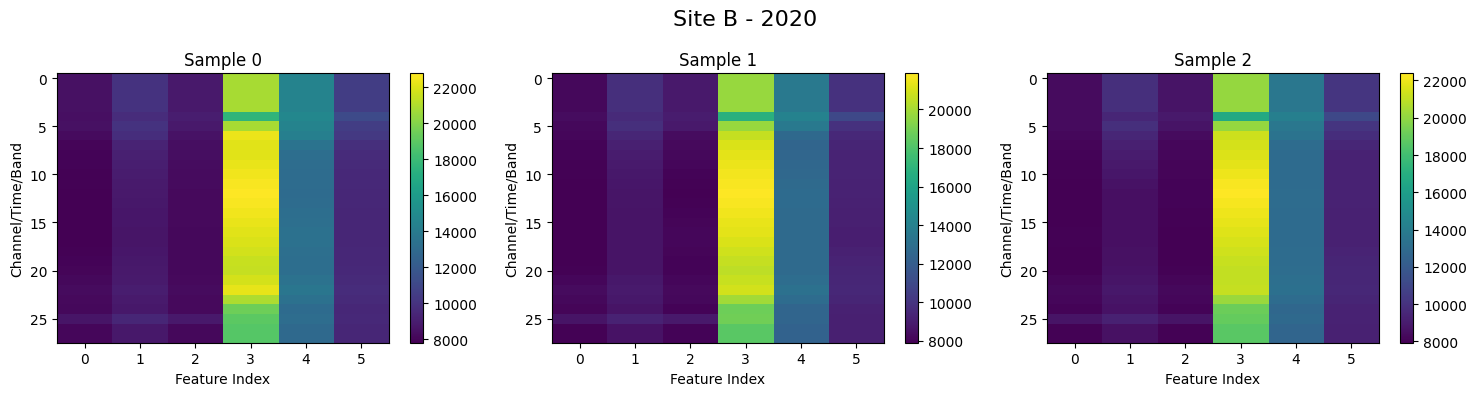

In [4]:
# Ploting the preprocessed feature maps
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i in range(3):
    im = axes[i].imshow(X[i], aspect='auto', cmap='viridis')
    axes[i].set_title(f"Sample {i}")
    axes[i].set_xlabel("Feature Index")
    axes[i].set_ylabel("Channel/Time/Band")
    fig.colorbar(im, ax=axes[i], orientation='vertical')

fig.suptitle(f"Site {SITE} - {YEAR}", fontsize=16)
plt.tight_layout()
plt.show()

In [5]:
print(f'\n\n======= For Site {SITE} - {YEAR} =======')
feature_means = X.mean(axis=(0, 1))  # average over samples and features
feature_stds = X.std(axis=(0, 1))

for i, (m, s) in enumerate(zip(feature_means, feature_stds)):
    print(f"Feature {i}: Mean = {m:.4f}, Std = {s:.4f}")

# Compute overall mean and std
mean = X.mean()
std = X.std()

print(f"\nGlobal Mean: {mean:.4f}")
print(f"Global Std Dev: {std:.4f}")



======= For Site B - 2020 =======
Feature 0: Mean = 9293.7332, Std = 1062.0828
Feature 1: Mean = 10402.3986, Std = 1328.2403
Feature 2: Mean = 10579.1004, Std = 1999.1082
Feature 3: Mean = 18968.7555, Std = 4274.7314
Feature 4: Mean = 16319.4431, Std = 3346.2848
Feature 5: Mean = 13205.7260, Std = 3494.6972

Global Mean: 13128.1928
Global Std Dev: 4500.1056


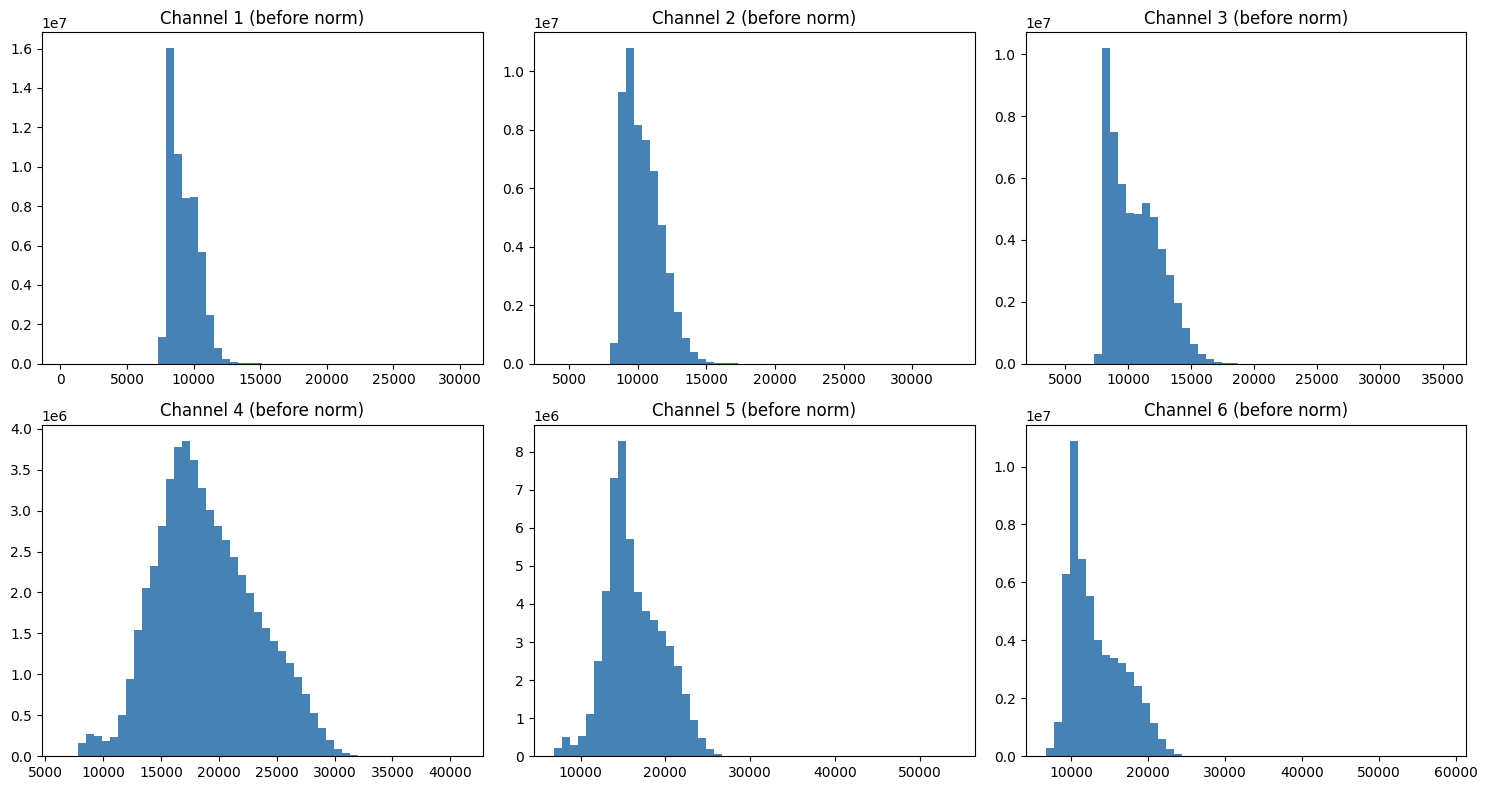

In [6]:
X_hist = X.reshape(-1, 6)  # shape: (N*T, 6)

# Before normalization
fig, axs = plt.subplots(2, 3, figsize=(15, 8))
axs = axs.ravel()

for i in range(6):
    axs[i].hist(X_hist[:, i], bins=50, color='steelblue', alpha=1)
    axs[i].set_title(f'Channel {i+1} (before norm)')
plt.tight_layout()
plt.show()

## Preprocessing the Input

In [7]:
# Standardizing the input features across all timesteps and samples using Z-scores
# Compute per-feature mean and std across all samples and timesteps
feature_means = X.mean(axis=(0, 1))  # Shape: (6,)
feature_stds = X.std(axis=(0, 1))    # Shape: (6,)

# Reshape for broadcasting
feature_means = feature_means.reshape(1, 1, -1)  # Shape: (1, 1, 6)
feature_stds = feature_stds.reshape(1, 1, -1)    # Shape: (1, 1, 6)

# Standardize
X = ((X - feature_means) / feature_stds).astype(np.float32)

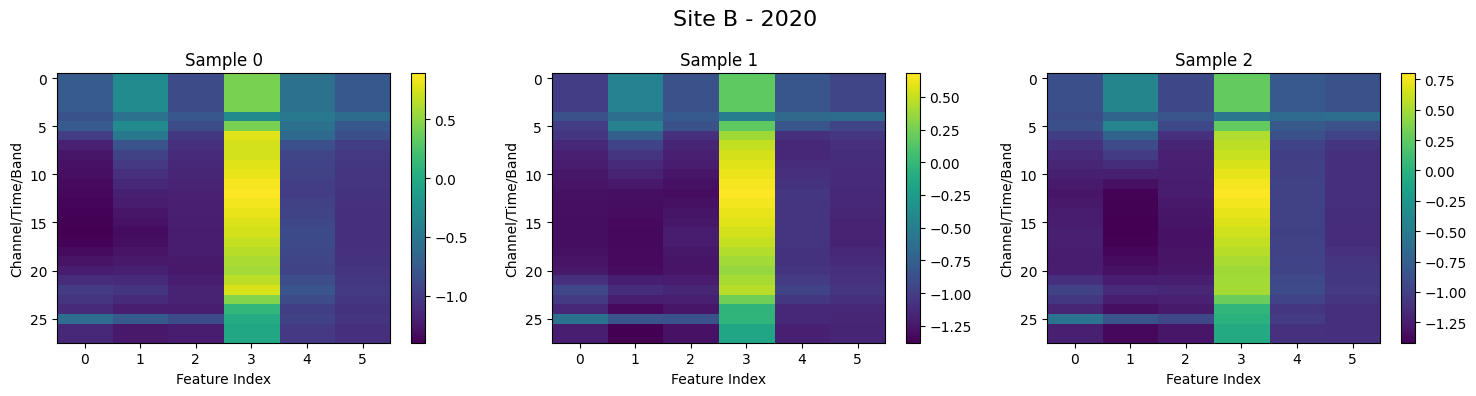

In [8]:
# Ploting the preprocessed feature maps
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i in range(3):
    im = axes[i].imshow(X[i], aspect='auto', cmap='viridis')
    axes[i].set_title(f"Sample {i}")
    axes[i].set_xlabel("Feature Index")
    axes[i].set_ylabel("Channel/Time/Band")
    fig.colorbar(im, ax=axes[i], orientation='vertical')

fig.suptitle(f"Site {SITE} - {YEAR}", fontsize=16)
plt.tight_layout()
plt.show()

In [9]:
print(f'\n\n======= For Site {SITE} - {YEAR} =======')
feature_means = X.mean(axis=(0, 1))  # average over samples and features
feature_stds = X.std(axis=(0, 1))

for i, (m, s) in enumerate(zip(feature_means, feature_stds)):
    print(f"Feature {i}: Mean = {m:.4f}, Std = {s:.4f}")

# Compute overall mean and std
mean = X.mean()
std = X.std()

print(f"\nGlobal Mean: {mean:.4f}")
print(f"Global Std Dev: {std:.4f}")



======= For Site B - 2020 =======
Feature 0: Mean = -0.0000, Std = 0.8846
Feature 1: Mean = -0.0000, Std = 0.8950
Feature 2: Mean = 0.0000, Std = 0.8862
Feature 3: Mean = 0.0001, Std = 0.9253
Feature 4: Mean = 0.0000, Std = 0.9230
Feature 5: Mean = 0.0000, Std = 0.8994

Global Mean: -0.0000
Global Std Dev: 1.0000


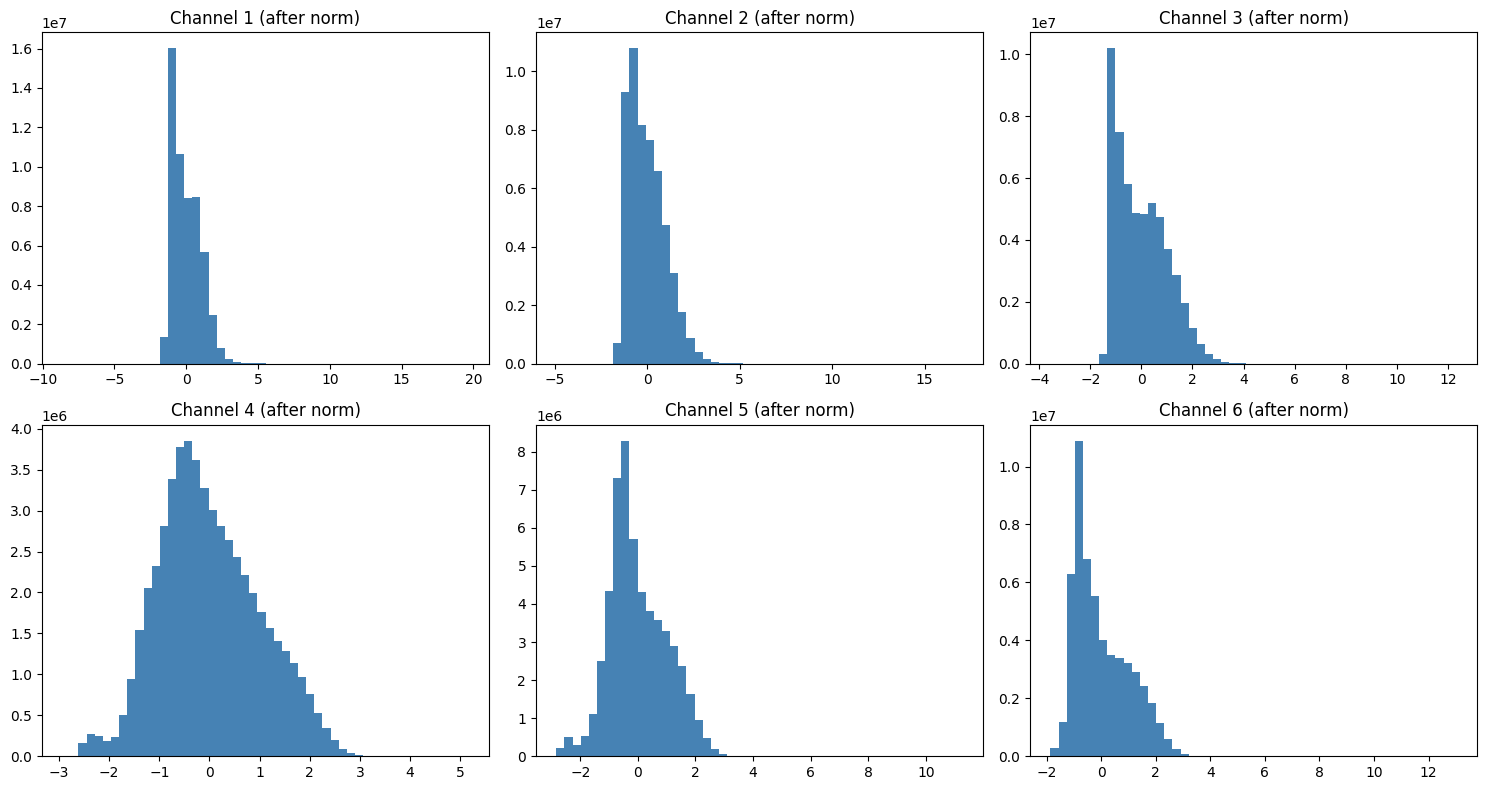

In [10]:
X_hist = X.reshape(-1, 6)  # shape: (N*T, 6)

# After normalization
fig, axs = plt.subplots(2, 3, figsize=(15, 8))
axs = axs.ravel()

for i in range(6):
    axs[i].hist(X_hist[:, i], bins=50, color='steelblue', alpha=1)
    axs[i].set_title(f'Channel {i+1} (after norm)')
plt.tight_layout()
plt.show()

## Label Distribution



====== Label Distribution ======
Label     Count     Percentage
------------------------------
0         871034    44.81%
1         260775    13.42%
2         811907    41.77%

Total samples: 1943716


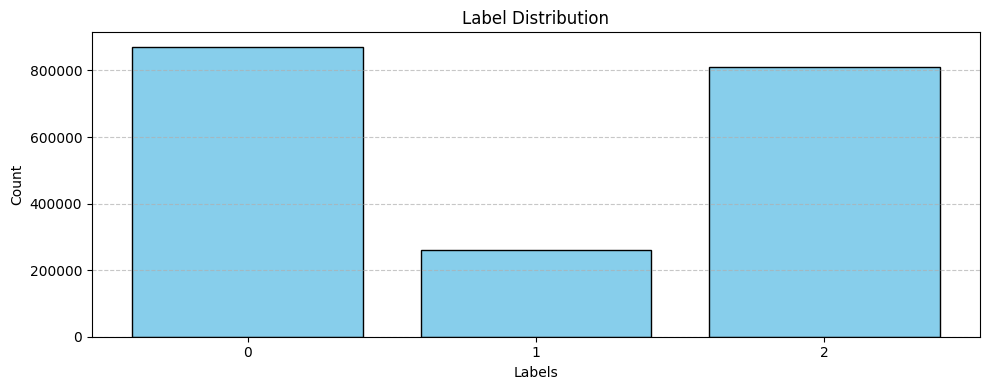

In [11]:
# Checking the label distribution of training data
print('\n\n====== Label Distribution ======')
unique_labels, counts = np.unique(y, return_counts=True)
total = counts.sum()
print(f"{'Label':<10}{'Count':<10}{'Percentage':<10}")
print("-" * 30)
for label, count in zip(unique_labels, counts):
    percentage = (count / total) * 100
    print(f"{label:<10}{count:<10}{percentage:<.2f}%")

print(f"\nTotal samples: {total}")

# Plot histogram for training data
unique_labels, counts = np.unique(y, return_counts=True)
plt.figure(figsize=(10, 4))
plt.bar(unique_labels.astype(str), counts, color='skyblue', edgecolor='black')
plt.xlabel("Labels")
plt.ylabel("Count")
plt.title(f"Label Distribution")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Data Splits

In [12]:
# Taking only 25% percent of the data
X_subset, X_test, y_subset, y_test = train_test_split(X, y, test_size=0.75, stratify=y, random_state=42)
print('Subset Data:', X_subset.shape, y_subset.shape)
print('Test Data:', X_test.shape, y_test.shape)

Subset Data: (485929, 28, 6) (485929,)
Test Data: (1457787, 28, 6) (1457787,)


In [13]:
# Train/Val Split
X_train, X_val, y_train, y_val = train_test_split(X_subset, y_subset, test_size=0.2, stratify=y_subset, random_state=42)
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(388743, 28, 6) (388743,)
(97186, 28, 6) (97186,)


In [14]:
# Checking if the training data is normalized correctly
print(f'\n\n======= Training data =======')
feature_means = X_train.mean(axis=(0, 1))  # average over samples and features
feature_stds = X_train.std(axis=(0, 1))

for i, (m, s) in enumerate(zip(feature_means, feature_stds)):
    print(f"Feature {i}: Mean = {m:.4f}, Std = {s:.4f}")

# Compute overall mean and std
mean = X_train.mean()
std = X_train.std()

print(f"\nGlobal Mean: {mean:.4f}")
print(f"Global Std Dev: {std:.4f}")



======= Training data =======
Feature 0: Mean = 0.0013, Std = 0.9957
Feature 1: Mean = 0.0013, Std = 0.9936
Feature 2: Mean = 0.0009, Std = 0.9921
Feature 3: Mean = 0.0006, Std = 0.9914
Feature 4: Mean = 0.0005, Std = 0.9904
Feature 5: Mean = 0.0004, Std = 0.9946

Global Mean: 0.0008
Global Std Dev: 1.0006




====== Label Distribution - Training data ======
Label     Count     Percentage
------------------------------
0         174206    44.81%
1         52155     13.42%
2         162382    41.77%

Total samples: 388743


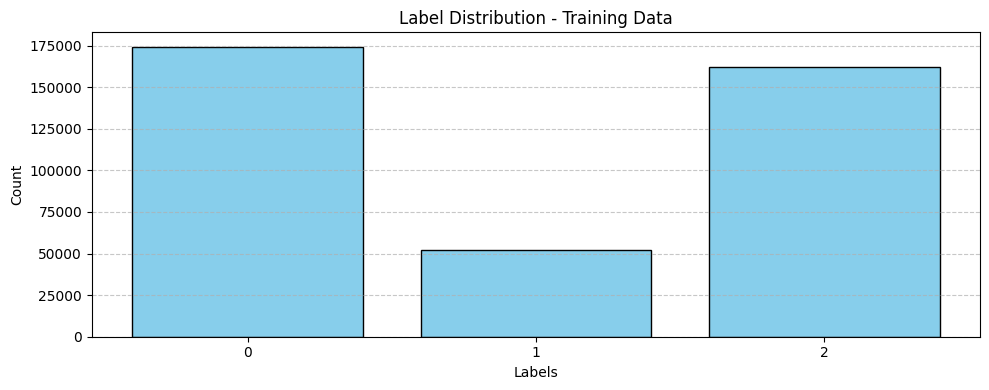

In [15]:
# Checking the label distribution of training data
print('\n\n====== Label Distribution - Training data ======')
unique_labels, counts = np.unique(y_train, return_counts=True)
total = counts.sum()
print(f"{'Label':<10}{'Count':<10}{'Percentage':<10}")
print("-" * 30)
for label, count in zip(unique_labels, counts):
    percentage = (count / total) * 100
    print(f"{label:<10}{count:<10}{percentage:<.2f}%")

print(f"\nTotal samples: {total}")

# Plot histogram for training data
unique_labels, counts = np.unique(y_train, return_counts=True)
plt.figure(figsize=(10, 4))
plt.bar(unique_labels.astype(str), counts, color='skyblue', edgecolor='black')
plt.xlabel("Labels")
plt.ylabel("Count")
plt.title(f"Label Distribution - Training Data")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Dataset and DataLoader

In [16]:
class Conv1dDataset(Dataset):
    def __init__(self, X, y):
        """
        X expected shape: (N, T, F)  -> convert to (N, C, L) with C=F, L=T
        Transpose to (N, F, T)
        """
        self.X = torch.tensor(X.transpose(0, 2, 1), dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [17]:
train_dataset = Conv1dDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

val_dataset = Conv1dDataset(X_val, y_val)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

test_dataset = Conv1dDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

## Model

In [18]:
# Blocks (Conv + FC) 
# ----------------------------
class Conv1d_BayesBlock(ModuleWrapperConv1d):
    """BBBConv1d + BN + ReLU inside a Conv1d wrapper"""
    def __init__(self, in_ch, out_ch, kernel_size, priors, device='cpu', padding=0):
        super().__init__()
        self.conv = BayesianConv1d(in_ch, out_ch, kernel_size, padding=padding, priors=priors, device=device)
        self.bn = nn.BatchNorm1d(out_ch)
        self.act = nn.ReLU()

class FCBayesBlock(ModuleWrapperLinear):
    """BBBLinear (optionally add activation if you want)"""
    def __init__(self, in_f, out_f, priors, device='cpu'):
        super().__init__()
        self.fc = BayesianLinear(in_f, out_f, priors=priors, device=device)

In [19]:
########################################
# Bayesian CNN + FC Model
########################################
class BayesianCNN_FC(nn.Module):
    def __init__(self, in_channels=6,  num_classes=3, priors=None, device='cpu'):
        super().__init__()
        self.device = device
        self.conv1 = Conv1d_BayesBlock(in_channels, 64, 5, priors, device=device, padding=2)
        self.conv2 = Conv1d_BayesBlock(64, 128, 5, priors, device=device, padding=2)
        self.conv3 = Conv1d_BayesBlock(128, 256, 5, priors, device=device, padding=2)
        self.conv4 = Conv1d_BayesBlock(256, 512, 5, priors, device=device, padding=2)
        self.conv5 = Conv1d_BayesBlock(512, 1024, 5, priors, device=device, padding=2)
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = FCBayesBlock(1024, num_classes, priors, device=device)

    def forward(self, x, sample=True, n_samples=1):
        # x: (batch, channels, length)  OR  (n_samples, batch, channels, length)
        kl_total = torch.tensor(0.0, device=x.device)

        x, kl = self.conv1(x, sample=sample, n_samples=n_samples); kl_total += kl
        x, kl = self.conv2(x, sample=sample, n_samples=n_samples); kl_total += kl
        x, kl = self.conv3(x, sample=sample, n_samples=n_samples); kl_total += kl
        x, kl = self.conv4(x, sample=sample, n_samples=n_samples); kl_total += kl
        x, kl = self.conv5(x, sample=sample, n_samples=n_samples); kl_total += kl

        # global pool (handle sample dim)
        if x.dim() == 4:  # (T, B, C, L)
            T_, B_, C_, L_ = x.shape
            x = x.reshape(T_ * B_, C_, L_)
            x = self.global_pool(x)             # (T*B, C, 1)
            x = x.squeeze(-1)                   # (T*B, C)
            x = x.reshape(T_, B_, C_)           # (T, B, C)
        elif x.dim() == 3:  # (B, C, L)
            x = self.global_pool(x)             # (B, C, 1)
            x = x.squeeze(-1)                   # (B, C)
        else:
            raise ValueError(f"Unexpected shape: {x.shape}")

        x, kl_fc = self.fc(x, sample=sample, n_samples=n_samples)
        kl_total += kl_fc

        return x, kl_total

In [20]:
########################################
# Model Initialization
########################################
if not flag_subsampled:
    model = BayesianCNN_FC(in_channels=6, num_classes=3, priors=PRIORS, device=DEVICE).to(DEVICE)
    model = torch.compile(model, backend='eager')
    print(model)
    
    # Loading model trained on SiteA-2019
    checkpoint = torch.load("/kaggle/input/bcnn/pytorch/default/1/BCNN.pth", map_location=torch.device("cpu"))
    model.load_state_dict(checkpoint)

## Evaluation Function

In [21]:
def compute_accuracy_per_sample_mean(outputs, labels):
    """
    outputs: (T, B, C) or (B, C)
    """
    if outputs.dim() == 3:
        preds = outputs.argmax(dim=2)               # (T, B)
        eq = (preds == labels.unsqueeze(0))         # (T, B)
        return eq.float().mean(dim=1).mean().item() # avg over T, then scalar
    else:
        preds = outputs.argmax(dim=1)
        return (preds == labels).float().mean().item()

In [22]:
def evaluate(model, dataloader, T, device):
    sample_flag = (T > 1)
    
    all_preds = []
    all_labels = []
    total_acc = 0.0

    model.eval()
    with torch.no_grad():
        for x_batch, y_batch in tqdm(dataloader, desc=f"Stochastic Validation (T={T})" if sample_flag else f"Deterministic Validation (T={T})"):
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            
            outputs, _ = model(x_batch, sample=sample_flag, n_samples=T)  # (T,B,C) or (B,C)

            # Accuracy before averaging predictions
            total_acc += compute_accuracy_per_sample_mean(outputs, y_batch) * x_batch.size(0)

            # Average over stochastic passes if T>1
            if sample_flag and outputs.dim() == 3:
                outputs = outputs.mean(dim=0)  # (B, C)

            # Get predictions
            probs = torch.softmax(outputs, dim=1)  # (B, C)
            preds = torch.argmax(probs, dim=1)

            all_preds.append(preds.cpu())
            all_labels.append(y_batch.cpu())

    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)

    # ====== Metrics ======
    kappa = cohen_kappa_score(all_labels.numpy(), all_preds.numpy())
    per_class_f1 = f1_score(all_labels.numpy(), all_preds.numpy(), average=None)
    avg_f1 = f1_score(all_labels.numpy(), all_preds.numpy(), average="macro")
    acc = total_acc / len(dataloader.dataset)
    cm = confusion_matrix(all_labels, all_preds)

    return acc, kappa, per_class_f1, avg_f1, cm

In [23]:
# acc, kappa, per_class_f1, avg_f1, cm = evaluate(model, test_dataloader, T, device=DEVICE)

# # Printing and plotting
# print("Stochastic" + f" Accuracy (mean over T): {acc:.4f}" if (T>1) else "Deterministic" + f" Accuracy (mean over T): {acc:.4f}")
# print(f"Cohen's Kappa: {kappa:.4f}")
# print(f"Per-class F1: {per_class_f1}")
# print(f"Average F1 (macro): {avg_f1:.4f}")

# disp = ConfusionMatrixDisplay(confusion_matrix=cm)
# disp.plot(cmap="Blues")
# plt.title(f"Confusion Matrix - Site {SITE} - {YEAR}")
# plt.tight_layout()
# plt.show()

## Training Loop

In [24]:
# ===== Class weights =====
all_labels = []
for _, y_batch in train_dataloader:
    all_labels.append(y_batch.numpy())

all_labels = np.concatenate(all_labels)
classes = np.unique(all_labels)
class_weights_np = compute_class_weight(class_weight='balanced',
                                        classes=classes, y=all_labels)
class_weights = torch.tensor(class_weights_np, dtype=torch.float).to(DEVICE)
class_weights = torch.clamp(class_weights, max=1.25) # Clipping to max 1.00
print("Class weights:", class_weights)

Class weights: tensor([0.7438, 1.2500, 0.7980], device='cuda:0')


In [25]:
# ===== Optimizer =====
if not flag_subsampled:
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [26]:
def ELBO_loss_nll_from_logits(outputs, y_batch, class_weights=None):
    """
    outputs: (T, B, C) or (B, C)
    y_batch: (B,)
    """
    if outputs.dim() == 3:
        T, B, C = outputs.shape
        outputs_flat = outputs.reshape(T * B, C)
        labels_rep = y_batch.unsqueeze(0).expand(T, B).reshape(T * B)
        return F.cross_entropy(outputs_flat, labels_rep,
                               weight=class_weights, reduction='mean')
    else:
        return F.cross_entropy(outputs, y_batch,
                               weight=class_weights, reduction='mean')

In [27]:
# ===== Training Loop =====
def train(model, train_dataset, train_loader, val_loader, optimizer, KL_WEIGHT=1e-8, EPOCHS=15, T=15):
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    
    for epoch in range(EPOCHS):
        # === TRAIN ===
        model.train()
        train_loss = 0.0
        train_acc = 0.0
    
        for x_batch, y_batch in tqdm(train_loader, desc=f'Training Epoch {epoch+1}'):
            x_batch = x_batch.to(DEVICE)
            y_batch = y_batch.to(DEVICE)
    
            optimizer.zero_grad()
    
            # Forward pass with T stochastic samples
            outputs, kl = model(x_batch, sample=True, n_samples=T)  # (T,B,C) + scalar KL
    
            # Mean NLL across T samples
            nll_mean = ELBO_loss_nll_from_logits(outputs, y_batch, class_weights)
            
            # ELBO Loss
            loss = nll_mean + KL_WEIGHT * kl
    
            # Backprop
            loss.backward()
            optimizer.step()
    
            # Stats
            train_loss += loss.item() * x_batch.size(0)
            train_acc += compute_accuracy_per_sample_mean(outputs, y_batch) * x_batch.size(0)
    
        train_loss /= len(train_dataset)
        train_acc /= len(train_dataset)
        print(f'Loss: {nll_mean:.4f} + {KL_WEIGHT} * {kl}')
    
        # === VALIDATION ===
        model.eval()
        val_loss = 0.0
        val_acc = 0.0
    
        with torch.no_grad():
            for x_batch, y_batch in tqdm(val_loader, desc='Validation'):
                x_batch = x_batch.to(DEVICE)
                y_batch = y_batch.to(DEVICE)
    
                outputs, kl = model(x_batch, sample=False, n_samples=1)  # deterministic eval
                nll = ELBO_loss_nll_from_logits(outputs, y_batch, class_weights)
                loss = nll + KL_WEIGHT * kl
    
                val_loss += loss.item() * x_batch.size(0)
                val_acc += compute_accuracy_per_sample_mean(outputs, y_batch) * x_batch.size(0)
    
        val_loss /= len(val_dataset)
        val_acc /= len(val_dataset)
    
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
    
        print(f"Epoch [{epoch+1}/{EPOCHS}] "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}") 

    return train_losses, val_losses, train_accs, val_accs

In [28]:
# Subsampled Training
def subsampled_training(X_train, y_train, val_dataloader, start, end, step):
    subset_sizes = list(range(start, end+1, step))
    print(subset_sizes)
    
    elbow_history = {
        "subset_size": [],
        "train_accuracy": [],
        "train_loss": [],
        "val_accuracy": [],
        "val_loss": [],
        "val_avg_f1": [],
        "kappa": []
    }
    
    for size in subset_sizes:
        print(f"\nTraining with {size} samples...")
        
        subset_indices = np.arange(size)
        X_subsample = X_train[subset_indices]
        y_subsample = y_train[subset_indices]
    
        # Create dataset & dataloader
        subsample_dataset = Conv1dDataset(X_subsample, y_subsample)
        subsample_loader = DataLoader(subsample_dataset, batch_size=BATCH_SIZE, shuffle=True)
    
        # Fresh model for each subset and optimizer
        model = BayesianCNN_FC(in_channels=6, num_classes=3, priors=PRIORS, device=DEVICE).to(DEVICE)
        model = torch.compile(model, backend='eager')
        checkpoint = torch.load("/kaggle/input/bcnn/pytorch/default/1/BCNN.pth", map_location=torch.device("cpu"))
        model.load_state_dict(checkpoint)
        optimizer = torch.optim.Adam(model.parameters(), lr=LR)  
    
        # Train
        train_losses, val_losses, train_accs, val_accs = train(model, subsample_dataset, subsample_loader, val_dataloader, optimizer, KL_WEIGHT=KL_WEIGHT, EPOCHS=EPOCHS, T=T)
        # Evaluate
        acc, kappa, per_class_f1, avg_f1, cm = evaluate(model, test_dataloader, T, device=DEVICE)
    
        # Printing and plotting
        print("Stochastic" + f" Accuracy (mean over T): {acc:.4f}" if (T>1) else "Deterministic" + f" Accuracy (mean over T): {acc:.4f}")
        print(f"Cohen's Kappa: {kappa:.4f}")
        print(f"Per-class F1: {per_class_f1}")
        print(f"Average F1 (macro): {avg_f1:.4f}")
        
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap="Blues")
        plt.title(f"Confusion Matrix - Site {SITE} - {YEAR}")
        plt.tight_layout()
        plt.show()
        
        # Save final epoch stats
        elbow_history["subset_size"].append(size)
        elbow_history["train_loss"].append(train_losses[-1])
        elbow_history["train_accuracy"].append(train_accs[-1])
        elbow_history["val_accuracy"].append(val_accs[-1])
        elbow_history["val_loss"].append(val_losses[-1])
        elbow_history["val_avg_f1"].append(avg_f1)
        elbow_history["kappa"].append(kappa)

    return elbow_history

## Training

[5000, 10000, 15000, 20000, 25000, 30000, 35000, 40000, 45000, 50000, 55000, 60000, 65000, 70000, 75000]

Training with 5000 samples...


Training Epoch 1: 100%|██████████| 79/79 [00:05<00:00, 13.64it/s]


Loss: 0.1535 + 1e-08 * 2869316.5


Validation: 100%|██████████| 1519/1519 [00:11<00:00, 134.93it/s]


Epoch [1/15] Train Loss: 0.6716, Train Acc: 0.7732 | Val Loss: 0.3971, Val Acc: 0.8565


Training Epoch 2: 100%|██████████| 79/79 [00:01<00:00, 44.71it/s]


Loss: 0.6023 + 1e-08 * 2864652.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.92it/s]


Epoch [2/15] Train Loss: 0.3628, Train Acc: 0.8682 | Val Loss: 0.3538, Val Acc: 0.8729


Training Epoch 3: 100%|██████████| 79/79 [00:01<00:00, 44.77it/s]


Loss: 0.5099 + 1e-08 * 2860289.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.37it/s]


Epoch [3/15] Train Loss: 0.3291, Train Acc: 0.8838 | Val Loss: 0.3415, Val Acc: 0.8786


Training Epoch 4: 100%|██████████| 79/79 [00:01<00:00, 44.75it/s]


Loss: 0.7351 + 1e-08 * 2854868.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.11it/s]


Epoch [4/15] Train Loss: 0.3008, Train Acc: 0.8894 | Val Loss: 0.3265, Val Acc: 0.8827


Training Epoch 5: 100%|██████████| 79/79 [00:01<00:00, 44.88it/s]


Loss: 0.4605 + 1e-08 * 2852246.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.16it/s]


Epoch [5/15] Train Loss: 0.2870, Train Acc: 0.8944 | Val Loss: 0.3304, Val Acc: 0.8779


Training Epoch 6: 100%|██████████| 79/79 [00:01<00:00, 44.67it/s]


Loss: 0.1062 + 1e-08 * 2846710.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.50it/s]


Epoch [6/15] Train Loss: 0.2672, Train Acc: 0.9060 | Val Loss: 0.3229, Val Acc: 0.8869


Training Epoch 7: 100%|██████████| 79/79 [00:01<00:00, 44.29it/s]


Loss: 0.3209 + 1e-08 * 2843187.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.07it/s]


Epoch [7/15] Train Loss: 0.2529, Train Acc: 0.9108 | Val Loss: 0.3221, Val Acc: 0.8863


Training Epoch 8: 100%|██████████| 79/79 [00:01<00:00, 44.90it/s]


Loss: 0.0651 + 1e-08 * 2840359.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 147.07it/s]


Epoch [8/15] Train Loss: 0.2366, Train Acc: 0.9184 | Val Loss: 0.3239, Val Acc: 0.8883


Training Epoch 9: 100%|██████████| 79/79 [00:01<00:00, 45.01it/s]


Loss: 0.0451 + 1e-08 * 2838686.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.22it/s]


Epoch [9/15] Train Loss: 0.2289, Train Acc: 0.9208 | Val Loss: 0.3262, Val Acc: 0.8853


Training Epoch 10: 100%|██████████| 79/79 [00:01<00:00, 44.97it/s]


Loss: 0.5215 + 1e-08 * 2839116.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 147.06it/s]


Epoch [10/15] Train Loss: 0.2154, Train Acc: 0.9236 | Val Loss: 0.3374, Val Acc: 0.8810


Training Epoch 11: 100%|██████████| 79/79 [00:01<00:00, 44.77it/s]


Loss: 0.6526 + 1e-08 * 2841051.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.96it/s]


Epoch [11/15] Train Loss: 0.2105, Train Acc: 0.9308 | Val Loss: 0.3445, Val Acc: 0.8822


Training Epoch 12: 100%|██████████| 79/79 [00:01<00:00, 44.38it/s]


Loss: 0.4866 + 1e-08 * 2844219.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 147.15it/s]


Epoch [12/15] Train Loss: 0.2038, Train Acc: 0.9308 | Val Loss: 0.3307, Val Acc: 0.8895


Training Epoch 13: 100%|██████████| 79/79 [00:01<00:00, 44.75it/s]


Loss: 0.2270 + 1e-08 * 2847663.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.64it/s]


Epoch [13/15] Train Loss: 0.1796, Train Acc: 0.9400 | Val Loss: 0.3383, Val Acc: 0.8878


Training Epoch 14: 100%|██████████| 79/79 [00:01<00:00, 44.57it/s]


Loss: 0.3028 + 1e-08 * 2849623.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.40it/s]


Epoch [14/15] Train Loss: 0.1682, Train Acc: 0.9456 | Val Loss: 0.3568, Val Acc: 0.8830


Training Epoch 15: 100%|██████████| 79/79 [00:01<00:00, 44.84it/s]


Loss: 0.5352 + 1e-08 * 2853524.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 147.27it/s]


Epoch [15/15] Train Loss: 0.1624, Train Acc: 0.9514 | Val Loss: 0.3916, Val Acc: 0.8747


Stochastic Validation (T=15): 100%|██████████| 22778/22778 [02:37<00:00, 144.24it/s]


Stochastic Accuracy (mean over T): 0.8752
Cohen's Kappa: 0.7946
Per-class F1: [0.86777347 0.90293693 0.8741236 ]
Average F1 (macro): 0.8816


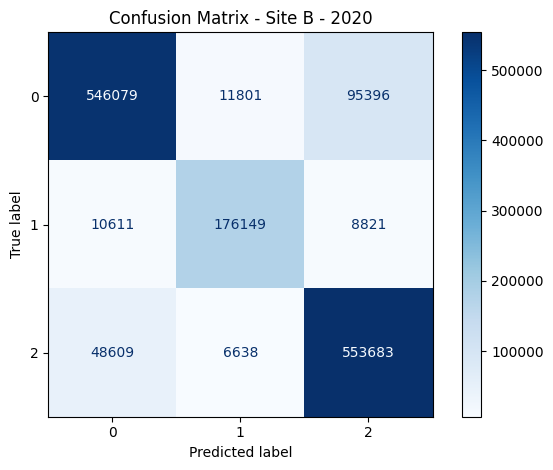


Training with 10000 samples...


Training Epoch 1: 100%|██████████| 157/157 [00:03<00:00, 44.54it/s]


Loss: 0.5701 + 1e-08 * 2866799.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.72it/s]


Epoch [1/15] Train Loss: 0.5302, Train Acc: 0.8236 | Val Loss: 0.3490, Val Acc: 0.8745


Training Epoch 2: 100%|██████████| 157/157 [00:03<00:00, 44.58it/s]


Loss: 0.5744 + 1e-08 * 2854425.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.22it/s]


Epoch [2/15] Train Loss: 0.3295, Train Acc: 0.8799 | Val Loss: 0.3188, Val Acc: 0.8857


Training Epoch 3: 100%|██████████| 157/157 [00:03<00:00, 44.64it/s]


Loss: 0.3068 + 1e-08 * 2841206.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.34it/s]


Epoch [3/15] Train Loss: 0.2985, Train Acc: 0.8958 | Val Loss: 0.3063, Val Acc: 0.8908


Training Epoch 4: 100%|██████████| 157/157 [00:03<00:00, 44.43it/s]


Loss: 0.2648 + 1e-08 * 2827528.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.51it/s]


Epoch [4/15] Train Loss: 0.2789, Train Acc: 0.9037 | Val Loss: 0.3032, Val Acc: 0.8946


Training Epoch 5: 100%|██████████| 157/157 [00:03<00:00, 44.75it/s]


Loss: 0.0902 + 1e-08 * 2817809.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.24it/s]


Epoch [5/15] Train Loss: 0.2625, Train Acc: 0.9092 | Val Loss: 0.3032, Val Acc: 0.8919


Training Epoch 6: 100%|██████████| 157/157 [00:03<00:00, 44.67it/s]


Loss: 0.3756 + 1e-08 * 2807929.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.42it/s]


Epoch [6/15] Train Loss: 0.2498, Train Acc: 0.9129 | Val Loss: 0.2996, Val Acc: 0.8951


Training Epoch 7: 100%|██████████| 157/157 [00:03<00:00, 44.20it/s]


Loss: 0.1831 + 1e-08 * 2802506.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.46it/s]


Epoch [7/15] Train Loss: 0.2367, Train Acc: 0.9191 | Val Loss: 0.3002, Val Acc: 0.8943


Training Epoch 8: 100%|██████████| 157/157 [00:03<00:00, 44.57it/s]


Loss: 0.3196 + 1e-08 * 2800865.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.98it/s]


Epoch [8/15] Train Loss: 0.2252, Train Acc: 0.9229 | Val Loss: 0.3109, Val Acc: 0.8926


Training Epoch 9: 100%|██████████| 157/157 [00:03<00:00, 44.36it/s]


Loss: 0.1376 + 1e-08 * 2798388.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.98it/s]


Epoch [9/15] Train Loss: 0.2094, Train Acc: 0.9311 | Val Loss: 0.3211, Val Acc: 0.8928


Training Epoch 10: 100%|██████████| 157/157 [00:03<00:00, 44.55it/s]


Loss: 0.1374 + 1e-08 * 2798992.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.56it/s]


Epoch [10/15] Train Loss: 0.1955, Train Acc: 0.9367 | Val Loss: 0.3277, Val Acc: 0.8904


Training Epoch 11: 100%|██████████| 157/157 [00:03<00:00, 44.60it/s]


Loss: 0.1979 + 1e-08 * 2800973.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.78it/s]


Epoch [11/15] Train Loss: 0.1904, Train Acc: 0.9387 | Val Loss: 0.3180, Val Acc: 0.8949


Training Epoch 12: 100%|██████████| 157/157 [00:03<00:00, 44.44it/s]


Loss: 0.1764 + 1e-08 * 2806835.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.34it/s]


Epoch [12/15] Train Loss: 0.1814, Train Acc: 0.9405 | Val Loss: 0.3196, Val Acc: 0.8935


Training Epoch 13: 100%|██████████| 157/157 [00:03<00:00, 44.59it/s]


Loss: 0.1360 + 1e-08 * 2811004.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.90it/s]


Epoch [13/15] Train Loss: 0.1653, Train Acc: 0.9468 | Val Loss: 0.3289, Val Acc: 0.8940


Training Epoch 14: 100%|██████████| 157/157 [00:03<00:00, 44.27it/s]


Loss: 0.0698 + 1e-08 * 2817878.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.77it/s]


Epoch [14/15] Train Loss: 0.1577, Train Acc: 0.9508 | Val Loss: 0.3434, Val Acc: 0.8901


Training Epoch 15: 100%|██████████| 157/157 [00:03<00:00, 44.65it/s]


Loss: 0.0632 + 1e-08 * 2825982.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.36it/s]


Epoch [15/15] Train Loss: 0.1449, Train Acc: 0.9539 | Val Loss: 0.3597, Val Acc: 0.8914


Stochastic Validation (T=15): 100%|██████████| 22778/22778 [02:37<00:00, 144.19it/s]


Stochastic Accuracy (mean over T): 0.8921
Cohen's Kappa: 0.8212
Per-class F1: [0.89202149 0.90090214 0.88934971]
Average F1 (macro): 0.8941


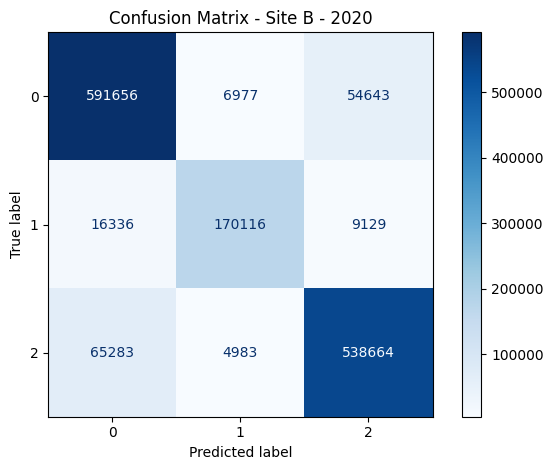


Training with 15000 samples...


Training Epoch 1: 100%|██████████| 235/235 [00:05<00:00, 44.55it/s]


Loss: 0.1909 + 1e-08 * 2860014.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.97it/s]


Epoch [1/15] Train Loss: 0.4732, Train Acc: 0.8401 | Val Loss: 0.3326, Val Acc: 0.8777


Training Epoch 2: 100%|██████████| 235/235 [00:05<00:00, 44.39it/s]


Loss: 0.2879 + 1e-08 * 2836359.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.71it/s]


Epoch [2/15] Train Loss: 0.3083, Train Acc: 0.8913 | Val Loss: 0.3061, Val Acc: 0.8901


Training Epoch 3: 100%|██████████| 235/235 [00:05<00:00, 44.38it/s]


Loss: 0.1756 + 1e-08 * 2811416.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.76it/s]


Epoch [3/15] Train Loss: 0.2841, Train Acc: 0.9009 | Val Loss: 0.3107, Val Acc: 0.8856


Training Epoch 4: 100%|██████████| 235/235 [00:05<00:00, 44.51it/s]


Loss: 0.1102 + 1e-08 * 2789361.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.05it/s]


Epoch [4/15] Train Loss: 0.2689, Train Acc: 0.9063 | Val Loss: 0.2939, Val Acc: 0.8967


Training Epoch 5: 100%|██████████| 235/235 [00:05<00:00, 44.27it/s]


Loss: 0.2113 + 1e-08 * 2769627.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.89it/s]


Epoch [5/15] Train Loss: 0.2537, Train Acc: 0.9132 | Val Loss: 0.2911, Val Acc: 0.8959


Training Epoch 6: 100%|██████████| 235/235 [00:05<00:00, 44.56it/s]


Loss: 0.1495 + 1e-08 * 2754213.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.14it/s]


Epoch [6/15] Train Loss: 0.2424, Train Acc: 0.9172 | Val Loss: 0.2941, Val Acc: 0.8983


Training Epoch 7: 100%|██████████| 235/235 [00:05<00:00, 44.41it/s]


Loss: 0.2177 + 1e-08 * 2740432.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.67it/s]


Epoch [7/15] Train Loss: 0.2322, Train Acc: 0.9215 | Val Loss: 0.2989, Val Acc: 0.8976


Training Epoch 8: 100%|██████████| 235/235 [00:05<00:00, 44.54it/s]


Loss: 0.1101 + 1e-08 * 2732074.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.39it/s]


Epoch [8/15] Train Loss: 0.2209, Train Acc: 0.9256 | Val Loss: 0.2918, Val Acc: 0.8971


Training Epoch 9: 100%|██████████| 235/235 [00:05<00:00, 44.35it/s]


Loss: 0.1947 + 1e-08 * 2729946.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.92it/s]


Epoch [9/15] Train Loss: 0.2122, Train Acc: 0.9287 | Val Loss: 0.3153, Val Acc: 0.8912


Training Epoch 10: 100%|██████████| 235/235 [00:05<00:00, 44.37it/s]


Loss: 0.2054 + 1e-08 * 2730728.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.15it/s]


Epoch [10/15] Train Loss: 0.2010, Train Acc: 0.9322 | Val Loss: 0.3038, Val Acc: 0.8978


Training Epoch 11: 100%|██████████| 235/235 [00:05<00:00, 44.49it/s]


Loss: 0.2214 + 1e-08 * 2733187.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.34it/s]


Epoch [11/15] Train Loss: 0.1891, Train Acc: 0.9363 | Val Loss: 0.3087, Val Acc: 0.8977


Training Epoch 12: 100%|██████████| 235/235 [00:05<00:00, 44.25it/s]


Loss: 0.1302 + 1e-08 * 2737581.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.91it/s]


Epoch [12/15] Train Loss: 0.1779, Train Acc: 0.9420 | Val Loss: 0.3162, Val Acc: 0.8947


Training Epoch 13: 100%|██████████| 235/235 [00:05<00:00, 44.39it/s]


Loss: 0.0338 + 1e-08 * 2742279.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.99it/s]


Epoch [13/15] Train Loss: 0.1684, Train Acc: 0.9467 | Val Loss: 0.3270, Val Acc: 0.8922


Training Epoch 14: 100%|██████████| 235/235 [00:05<00:00, 44.17it/s]


Loss: 0.0371 + 1e-08 * 2753102.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.85it/s]


Epoch [14/15] Train Loss: 0.1642, Train Acc: 0.9471 | Val Loss: 0.3315, Val Acc: 0.8933


Training Epoch 15: 100%|██████████| 235/235 [00:05<00:00, 44.49it/s]


Loss: 0.2328 + 1e-08 * 2760258.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.27it/s]


Epoch [15/15] Train Loss: 0.1545, Train Acc: 0.9509 | Val Loss: 0.3376, Val Acc: 0.8950


Stochastic Validation (T=15): 100%|██████████| 22778/22778 [02:37<00:00, 144.36it/s]


Stochastic Accuracy (mean over T): 0.8951
Cohen's Kappa: 0.8267
Per-class F1: [0.8952197  0.90824825 0.8908152 ]
Average F1 (macro): 0.8981


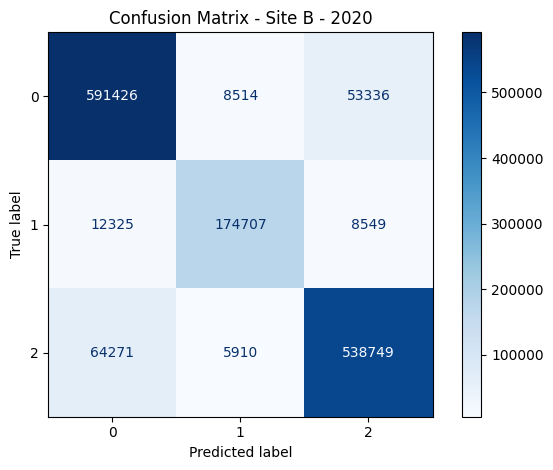


Training with 20000 samples...


Training Epoch 1: 100%|██████████| 313/313 [00:07<00:00, 44.60it/s]


Loss: 0.4407 + 1e-08 * 2850980.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.08it/s]


Epoch [1/15] Train Loss: 0.4310, Train Acc: 0.8497 | Val Loss: 0.3203, Val Acc: 0.8864


Training Epoch 2: 100%|██████████| 313/313 [00:07<00:00, 44.53it/s]


Loss: 0.2578 + 1e-08 * 2818446.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.03it/s]


Epoch [2/15] Train Loss: 0.3045, Train Acc: 0.8922 | Val Loss: 0.2975, Val Acc: 0.8929


Training Epoch 3: 100%|██████████| 313/313 [00:07<00:00, 44.64it/s]


Loss: 0.2575 + 1e-08 * 2785124.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.91it/s]


Epoch [3/15] Train Loss: 0.2816, Train Acc: 0.9011 | Val Loss: 0.2953, Val Acc: 0.8947


Training Epoch 4: 100%|██████████| 313/313 [00:07<00:00, 44.48it/s]


Loss: 0.3621 + 1e-08 * 2752803.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.21it/s]


Epoch [4/15] Train Loss: 0.2657, Train Acc: 0.9079 | Val Loss: 0.2884, Val Acc: 0.8979


Training Epoch 5: 100%|██████████| 313/313 [00:07<00:00, 44.50it/s]


Loss: 0.3438 + 1e-08 * 2727830.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.22it/s]


Epoch [5/15] Train Loss: 0.2563, Train Acc: 0.9122 | Val Loss: 0.2846, Val Acc: 0.8995


Training Epoch 6: 100%|██████████| 313/313 [00:07<00:00, 44.46it/s]


Loss: 0.4672 + 1e-08 * 2705593.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.06it/s]


Epoch [6/15] Train Loss: 0.2417, Train Acc: 0.9172 | Val Loss: 0.2804, Val Acc: 0.9012


Training Epoch 7: 100%|██████████| 313/313 [00:07<00:00, 44.60it/s]


Loss: 0.1151 + 1e-08 * 2691149.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.16it/s]


Epoch [7/15] Train Loss: 0.2342, Train Acc: 0.9172 | Val Loss: 0.2849, Val Acc: 0.9007


Training Epoch 8: 100%|██████████| 313/313 [00:07<00:00, 44.55it/s]


Loss: 0.3653 + 1e-08 * 2678158.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.78it/s]


Epoch [8/15] Train Loss: 0.2207, Train Acc: 0.9253 | Val Loss: 0.2816, Val Acc: 0.9026


Training Epoch 9: 100%|██████████| 313/313 [00:07<00:00, 44.55it/s]


Loss: 0.2608 + 1e-08 * 2670647.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.59it/s]


Epoch [9/15] Train Loss: 0.2129, Train Acc: 0.9290 | Val Loss: 0.2898, Val Acc: 0.8988


Training Epoch 10: 100%|██████████| 313/313 [00:07<00:00, 44.63it/s]


Loss: 0.1070 + 1e-08 * 2671588.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.63it/s]


Epoch [10/15] Train Loss: 0.2049, Train Acc: 0.9304 | Val Loss: 0.2984, Val Acc: 0.8937


Training Epoch 11: 100%|██████████| 313/313 [00:07<00:00, 44.67it/s]


Loss: 0.2239 + 1e-08 * 2669524.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.80it/s]


Epoch [11/15] Train Loss: 0.1945, Train Acc: 0.9349 | Val Loss: 0.3334, Val Acc: 0.8854


Training Epoch 12: 100%|██████████| 313/313 [00:07<00:00, 44.49it/s]


Loss: 0.1285 + 1e-08 * 2673978.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.11it/s]


Epoch [12/15] Train Loss: 0.1870, Train Acc: 0.9364 | Val Loss: 0.2966, Val Acc: 0.8975


Training Epoch 13: 100%|██████████| 313/313 [00:07<00:00, 44.40it/s]


Loss: 0.0646 + 1e-08 * 2678587.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.67it/s]


Epoch [13/15] Train Loss: 0.1784, Train Acc: 0.9406 | Val Loss: 0.3138, Val Acc: 0.8963


Training Epoch 14: 100%|██████████| 313/313 [00:07<00:00, 44.56it/s]


Loss: 0.0810 + 1e-08 * 2688038.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.99it/s]


Epoch [14/15] Train Loss: 0.1690, Train Acc: 0.9447 | Val Loss: 0.3130, Val Acc: 0.8958


Training Epoch 15: 100%|██████████| 313/313 [00:07<00:00, 44.59it/s]


Loss: 0.0875 + 1e-08 * 2696803.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.62it/s]


Epoch [15/15] Train Loss: 0.1598, Train Acc: 0.9488 | Val Loss: 0.3163, Val Acc: 0.8978


Stochastic Validation (T=15): 100%|██████████| 22778/22778 [02:38<00:00, 144.10it/s]


Stochastic Accuracy (mean over T): 0.8976
Cohen's Kappa: 0.8313
Per-class F1: [0.89774281 0.90951924 0.89361358]
Average F1 (macro): 0.9003


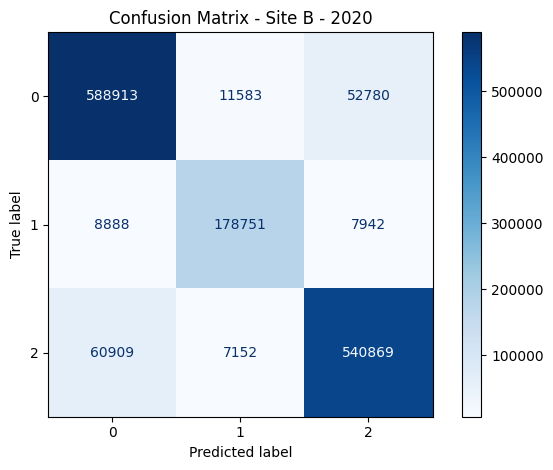


Training with 25000 samples...


Training Epoch 1: 100%|██████████| 391/391 [00:08<00:00, 44.59it/s]


Loss: 0.1507 + 1e-08 * 2839511.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.80it/s]


Epoch [1/15] Train Loss: 0.4049, Train Acc: 0.8570 | Val Loss: 0.3125, Val Acc: 0.8887


Training Epoch 2: 100%|██████████| 391/391 [00:08<00:00, 44.56it/s]


Loss: 0.2330 + 1e-08 * 2795537.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.91it/s]


Epoch [2/15] Train Loss: 0.2989, Train Acc: 0.8948 | Val Loss: 0.2969, Val Acc: 0.8941


Training Epoch 3: 100%|██████████| 391/391 [00:08<00:00, 44.53it/s]


Loss: 0.1950 + 1e-08 * 2751998.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.02it/s]


Epoch [3/15] Train Loss: 0.2797, Train Acc: 0.9020 | Val Loss: 0.2840, Val Acc: 0.9002


Training Epoch 4: 100%|██████████| 391/391 [00:08<00:00, 44.51it/s]


Loss: 0.1933 + 1e-08 * 2709807.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.29it/s]


Epoch [4/15] Train Loss: 0.2641, Train Acc: 0.9083 | Val Loss: 0.2813, Val Acc: 0.8997


Training Epoch 5: 100%|██████████| 391/391 [00:08<00:00, 44.47it/s]


Loss: 0.1487 + 1e-08 * 2676039.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.96it/s]


Epoch [5/15] Train Loss: 0.2547, Train Acc: 0.9110 | Val Loss: 0.2891, Val Acc: 0.8947


Training Epoch 6: 100%|██████████| 391/391 [00:08<00:00, 44.49it/s]


Loss: 0.1748 + 1e-08 * 2651221.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.60it/s]


Epoch [6/15] Train Loss: 0.2442, Train Acc: 0.9156 | Val Loss: 0.2805, Val Acc: 0.8999


Training Epoch 7: 100%|██████████| 391/391 [00:08<00:00, 44.50it/s]


Loss: 0.1605 + 1e-08 * 2632821.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.23it/s]


Epoch [7/15] Train Loss: 0.2369, Train Acc: 0.9172 | Val Loss: 0.2777, Val Acc: 0.9030


Training Epoch 8: 100%|██████████| 391/391 [00:08<00:00, 44.61it/s]


Loss: 0.0999 + 1e-08 * 2620749.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.17it/s]


Epoch [8/15] Train Loss: 0.2272, Train Acc: 0.9210 | Val Loss: 0.2771, Val Acc: 0.9022


Training Epoch 9: 100%|██████████| 391/391 [00:08<00:00, 44.49it/s]


Loss: 0.1537 + 1e-08 * 2611271.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.60it/s]


Epoch [9/15] Train Loss: 0.2147, Train Acc: 0.9261 | Val Loss: 0.2978, Val Acc: 0.8958


Training Epoch 10: 100%|██████████| 391/391 [00:08<00:00, 44.56it/s]


Loss: 0.1604 + 1e-08 * 2611399.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.34it/s]


Epoch [10/15] Train Loss: 0.2094, Train Acc: 0.9288 | Val Loss: 0.2864, Val Acc: 0.8986


Training Epoch 11: 100%|██████████| 391/391 [00:08<00:00, 44.58it/s]


Loss: 0.1892 + 1e-08 * 2611929.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.64it/s]


Epoch [11/15] Train Loss: 0.1984, Train Acc: 0.9312 | Val Loss: 0.3088, Val Acc: 0.8918


Training Epoch 12: 100%|██████████| 391/391 [00:08<00:00, 44.50it/s]


Loss: 0.1971 + 1e-08 * 2618746.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.25it/s]


Epoch [12/15] Train Loss: 0.1916, Train Acc: 0.9338 | Val Loss: 0.3066, Val Acc: 0.8957


Training Epoch 13: 100%|██████████| 391/391 [00:08<00:00, 44.59it/s]


Loss: 0.2775 + 1e-08 * 2625100.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.51it/s]


Epoch [13/15] Train Loss: 0.1807, Train Acc: 0.9385 | Val Loss: 0.3042, Val Acc: 0.8971


Training Epoch 14: 100%|██████████| 391/391 [00:08<00:00, 44.60it/s]


Loss: 0.2635 + 1e-08 * 2634764.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.04it/s]


Epoch [14/15] Train Loss: 0.1736, Train Acc: 0.9412 | Val Loss: 0.3030, Val Acc: 0.9001


Training Epoch 15: 100%|██████████| 391/391 [00:08<00:00, 44.52it/s]


Loss: 0.1155 + 1e-08 * 2646803.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.00it/s]


Epoch [15/15] Train Loss: 0.1638, Train Acc: 0.9464 | Val Loss: 0.3245, Val Acc: 0.8939


Stochastic Validation (T=15): 100%|██████████| 22778/22778 [02:37<00:00, 144.70it/s]


Stochastic Accuracy (mean over T): 0.8946
Cohen's Kappa: 0.8267
Per-class F1: [0.89465053 0.90148822 0.89238185]
Average F1 (macro): 0.8962


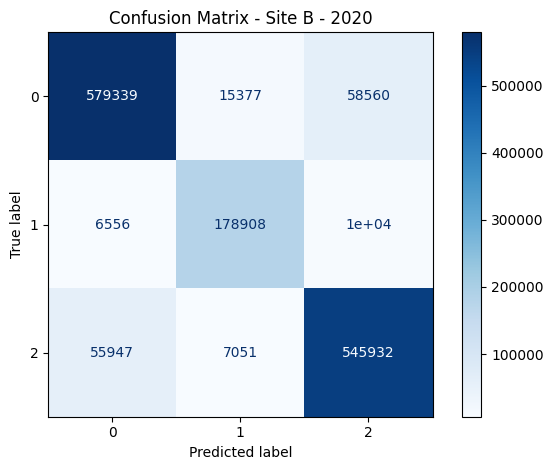


Training with 30000 samples...


Training Epoch 1: 100%|██████████| 469/469 [00:10<00:00, 44.50it/s]


Loss: 0.4714 + 1e-08 * 2833525.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.21it/s]


Epoch [1/15] Train Loss: 0.3972, Train Acc: 0.8619 | Val Loss: 0.3103, Val Acc: 0.8859


Training Epoch 2: 100%|██████████| 469/469 [00:10<00:00, 44.61it/s]


Loss: 0.1194 + 1e-08 * 2780767.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.44it/s]


Epoch [2/15] Train Loss: 0.2959, Train Acc: 0.8941 | Val Loss: 0.2849, Val Acc: 0.8994


Training Epoch 3: 100%|██████████| 469/469 [00:10<00:00, 44.62it/s]


Loss: 0.2655 + 1e-08 * 2724580.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.26it/s]


Epoch [3/15] Train Loss: 0.2762, Train Acc: 0.9040 | Val Loss: 0.2878, Val Acc: 0.9000


Training Epoch 4: 100%|██████████| 469/469 [00:10<00:00, 44.51it/s]


Loss: 0.2227 + 1e-08 * 2675715.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.77it/s]


Epoch [4/15] Train Loss: 0.2643, Train Acc: 0.9071 | Val Loss: 0.2771, Val Acc: 0.9019


Training Epoch 5: 100%|██████████| 469/469 [00:10<00:00, 44.40it/s]


Loss: 0.1542 + 1e-08 * 2636258.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.26it/s]


Epoch [5/15] Train Loss: 0.2541, Train Acc: 0.9114 | Val Loss: 0.2800, Val Acc: 0.8991


Training Epoch 6: 100%|██████████| 469/469 [00:10<00:00, 44.59it/s]


Loss: 0.2901 + 1e-08 * 2605063.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.14it/s]


Epoch [6/15] Train Loss: 0.2446, Train Acc: 0.9146 | Val Loss: 0.2823, Val Acc: 0.8992


Training Epoch 7: 100%|██████████| 469/469 [00:10<00:00, 44.61it/s]


Loss: 0.3330 + 1e-08 * 2581255.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.89it/s]


Epoch [7/15] Train Loss: 0.2350, Train Acc: 0.9181 | Val Loss: 0.2725, Val Acc: 0.9047


Training Epoch 8: 100%|██████████| 469/469 [00:10<00:00, 44.56it/s]


Loss: 0.1587 + 1e-08 * 2565841.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.57it/s]


Epoch [8/15] Train Loss: 0.2278, Train Acc: 0.9203 | Val Loss: 0.2749, Val Acc: 0.9014


Training Epoch 9: 100%|██████████| 469/469 [00:10<00:00, 44.56it/s]


Loss: 0.3318 + 1e-08 * 2557502.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.16it/s]


Epoch [9/15] Train Loss: 0.2154, Train Acc: 0.9244 | Val Loss: 0.2764, Val Acc: 0.9027


Training Epoch 10: 100%|██████████| 469/469 [00:10<00:00, 44.60it/s]


Loss: 0.1182 + 1e-08 * 2556866.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.69it/s]


Epoch [10/15] Train Loss: 0.2100, Train Acc: 0.9277 | Val Loss: 0.2859, Val Acc: 0.9007


Training Epoch 11: 100%|██████████| 469/469 [00:10<00:00, 44.62it/s]


Loss: 0.1943 + 1e-08 * 2556973.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.78it/s]


Epoch [11/15] Train Loss: 0.2014, Train Acc: 0.9304 | Val Loss: 0.2784, Val Acc: 0.9029


Training Epoch 12: 100%|██████████| 469/469 [00:10<00:00, 44.49it/s]


Loss: 0.1195 + 1e-08 * 2562154.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.19it/s]


Epoch [12/15] Train Loss: 0.1901, Train Acc: 0.9358 | Val Loss: 0.2857, Val Acc: 0.9034


Training Epoch 13: 100%|██████████| 469/469 [00:10<00:00, 44.50it/s]


Loss: 0.1212 + 1e-08 * 2569368.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.71it/s]


Epoch [13/15] Train Loss: 0.1853, Train Acc: 0.9364 | Val Loss: 0.2927, Val Acc: 0.9007


Training Epoch 14: 100%|██████████| 469/469 [00:10<00:00, 44.49it/s]


Loss: 0.0987 + 1e-08 * 2581345.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.07it/s]


Epoch [14/15] Train Loss: 0.1762, Train Acc: 0.9402 | Val Loss: 0.2962, Val Acc: 0.9008


Training Epoch 15: 100%|██████████| 469/469 [00:10<00:00, 44.39it/s]


Loss: 0.3455 + 1e-08 * 2594834.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.31it/s]


Epoch [15/15] Train Loss: 0.1695, Train Acc: 0.9428 | Val Loss: 0.3056, Val Acc: 0.9005


Stochastic Validation (T=15): 100%|██████████| 22778/22778 [02:38<00:00, 144.05it/s]


Stochastic Accuracy (mean over T): 0.9007
Cohen's Kappa: 0.8364
Per-class F1: [0.90207813 0.90857022 0.89666601]
Average F1 (macro): 0.9024


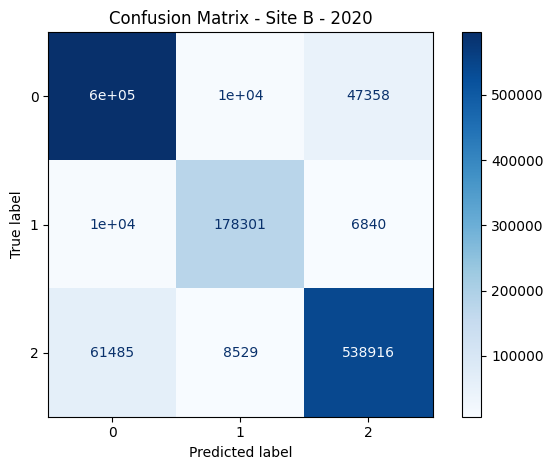


Training with 35000 samples...


Training Epoch 1: 100%|██████████| 547/547 [00:12<00:00, 44.22it/s]


Loss: 0.4531 + 1e-08 * 2825072.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.52it/s]


Epoch [1/15] Train Loss: 0.3829, Train Acc: 0.8642 | Val Loss: 0.3096, Val Acc: 0.8882


Training Epoch 2: 100%|██████████| 547/547 [00:12<00:00, 44.39it/s]


Loss: 0.2289 + 1e-08 * 2761357.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.26it/s]


Epoch [2/15] Train Loss: 0.2931, Train Acc: 0.8957 | Val Loss: 0.2985, Val Acc: 0.8941


Training Epoch 3: 100%|██████████| 547/547 [00:12<00:00, 44.26it/s]


Loss: 0.4544 + 1e-08 * 2701606.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.18it/s]


Epoch [3/15] Train Loss: 0.2761, Train Acc: 0.9027 | Val Loss: 0.2903, Val Acc: 0.8949


Training Epoch 4: 100%|██████████| 547/547 [00:12<00:00, 44.27it/s]


Loss: 0.1655 + 1e-08 * 2650816.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.90it/s]


Epoch [4/15] Train Loss: 0.2615, Train Acc: 0.9084 | Val Loss: 0.2715, Val Acc: 0.9018


Training Epoch 5: 100%|██████████| 547/547 [00:12<00:00, 44.32it/s]


Loss: 0.3434 + 1e-08 * 2604683.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.98it/s]


Epoch [5/15] Train Loss: 0.2509, Train Acc: 0.9117 | Val Loss: 0.2685, Val Acc: 0.9044


Training Epoch 6: 100%|██████████| 547/547 [00:12<00:00, 44.43it/s]


Loss: 0.3279 + 1e-08 * 2573347.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.56it/s]


Epoch [6/15] Train Loss: 0.2445, Train Acc: 0.9132 | Val Loss: 0.2880, Val Acc: 0.8954


Training Epoch 7: 100%|██████████| 547/547 [00:12<00:00, 44.50it/s]


Loss: 0.1991 + 1e-08 * 2545928.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.88it/s]


Epoch [7/15] Train Loss: 0.2347, Train Acc: 0.9188 | Val Loss: 0.2711, Val Acc: 0.9026


Training Epoch 8: 100%|██████████| 547/547 [00:12<00:00, 44.49it/s]


Loss: 0.1464 + 1e-08 * 2527686.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.36it/s]


Epoch [8/15] Train Loss: 0.2259, Train Acc: 0.9211 | Val Loss: 0.2678, Val Acc: 0.9050


Training Epoch 9: 100%|██████████| 547/547 [00:12<00:00, 44.40it/s]


Loss: 0.3148 + 1e-08 * 2518860.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.39it/s]


Epoch [9/15] Train Loss: 0.2187, Train Acc: 0.9233 | Val Loss: 0.2764, Val Acc: 0.9006


Training Epoch 10: 100%|██████████| 547/547 [00:12<00:00, 44.45it/s]


Loss: 0.2510 + 1e-08 * 2511935.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.55it/s]


Epoch [10/15] Train Loss: 0.2114, Train Acc: 0.9253 | Val Loss: 0.2769, Val Acc: 0.9063


Training Epoch 11: 100%|██████████| 547/547 [00:12<00:00, 44.41it/s]


Loss: 0.2781 + 1e-08 * 2511397.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.39it/s]


Epoch [11/15] Train Loss: 0.2020, Train Acc: 0.9309 | Val Loss: 0.2787, Val Acc: 0.9015


Training Epoch 12: 100%|██████████| 547/547 [00:12<00:00, 44.41it/s]


Loss: 0.3499 + 1e-08 * 2516851.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.50it/s]


Epoch [12/15] Train Loss: 0.1967, Train Acc: 0.9305 | Val Loss: 0.2819, Val Acc: 0.9045


Training Epoch 13: 100%|██████████| 547/547 [00:12<00:00, 44.43it/s]


Loss: 0.0940 + 1e-08 * 2522488.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.38it/s]


Epoch [13/15] Train Loss: 0.1862, Train Acc: 0.9363 | Val Loss: 0.2848, Val Acc: 0.9002


Training Epoch 14: 100%|██████████| 547/547 [00:12<00:00, 44.43it/s]


Loss: 0.1909 + 1e-08 * 2535590.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.91it/s]


Epoch [14/15] Train Loss: 0.1784, Train Acc: 0.9381 | Val Loss: 0.2904, Val Acc: 0.9037


Training Epoch 15: 100%|██████████| 547/547 [00:12<00:00, 44.49it/s]


Loss: 0.0656 + 1e-08 * 2548704.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.05it/s]


Epoch [15/15] Train Loss: 0.1750, Train Acc: 0.9397 | Val Loss: 0.3004, Val Acc: 0.8993


Stochastic Validation (T=15): 100%|██████████| 22778/22778 [02:37<00:00, 144.31it/s]


Stochastic Accuracy (mean over T): 0.8984
Cohen's Kappa: 0.8326
Per-class F1: [0.89913533 0.91126106 0.89339099]
Average F1 (macro): 0.9013


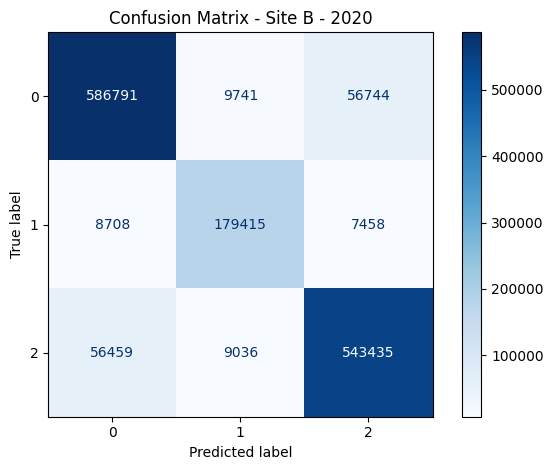


Training with 40000 samples...


Training Epoch 1: 100%|██████████| 625/625 [00:14<00:00, 44.48it/s]


Loss: 0.1852 + 1e-08 * 2814374.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.96it/s]


Epoch [1/15] Train Loss: 0.3741, Train Acc: 0.8660 | Val Loss: 0.2977, Val Acc: 0.8935


Training Epoch 2: 100%|██████████| 625/625 [00:14<00:00, 44.59it/s]


Loss: 0.2314 + 1e-08 * 2736548.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.21it/s]


Epoch [2/15] Train Loss: 0.2895, Train Acc: 0.8973 | Val Loss: 0.2819, Val Acc: 0.8982


Training Epoch 3: 100%|██████████| 625/625 [00:14<00:00, 44.48it/s]


Loss: 0.3371 + 1e-08 * 2668893.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.65it/s]


Epoch [3/15] Train Loss: 0.2712, Train Acc: 0.9051 | Val Loss: 0.2708, Val Acc: 0.9036


Training Epoch 4: 100%|██████████| 625/625 [00:14<00:00, 44.36it/s]


Loss: 0.1603 + 1e-08 * 2610256.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.27it/s]


Epoch [4/15] Train Loss: 0.2591, Train Acc: 0.9090 | Val Loss: 0.2666, Val Acc: 0.9054


Training Epoch 5: 100%|██████████| 625/625 [00:14<00:00, 44.41it/s]


Loss: 0.2711 + 1e-08 * 2565185.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.15it/s]


Epoch [5/15] Train Loss: 0.2470, Train Acc: 0.9137 | Val Loss: 0.2656, Val Acc: 0.9067


Training Epoch 6: 100%|██████████| 625/625 [00:14<00:00, 44.37it/s]


Loss: 0.2304 + 1e-08 * 2533547.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.31it/s]


Epoch [6/15] Train Loss: 0.2396, Train Acc: 0.9149 | Val Loss: 0.3050, Val Acc: 0.8864


Training Epoch 7: 100%|██████████| 625/625 [00:14<00:00, 44.39it/s]


Loss: 0.1795 + 1e-08 * 2512076.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.74it/s]


Epoch [7/15] Train Loss: 0.2324, Train Acc: 0.9186 | Val Loss: 0.2695, Val Acc: 0.9039


Training Epoch 8: 100%|██████████| 625/625 [00:14<00:00, 44.41it/s]


Loss: 0.2084 + 1e-08 * 2495751.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.46it/s]


Epoch [8/15] Train Loss: 0.2227, Train Acc: 0.9217 | Val Loss: 0.2669, Val Acc: 0.9066


Training Epoch 9: 100%|██████████| 625/625 [00:14<00:00, 44.49it/s]


Loss: 0.2406 + 1e-08 * 2487232.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.40it/s]


Epoch [9/15] Train Loss: 0.2155, Train Acc: 0.9248 | Val Loss: 0.2706, Val Acc: 0.9053


Training Epoch 10: 100%|██████████| 625/625 [00:14<00:00, 44.28it/s]


Loss: 0.2544 + 1e-08 * 2480925.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.34it/s]


Epoch [10/15] Train Loss: 0.2089, Train Acc: 0.9271 | Val Loss: 0.2722, Val Acc: 0.9039


Training Epoch 11: 100%|██████████| 625/625 [00:14<00:00, 44.36it/s]


Loss: 0.1769 + 1e-08 * 2480989.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.35it/s]


Epoch [11/15] Train Loss: 0.2008, Train Acc: 0.9295 | Val Loss: 0.2770, Val Acc: 0.9023


Training Epoch 12: 100%|██████████| 625/625 [00:14<00:00, 44.41it/s]


Loss: 0.2078 + 1e-08 * 2486668.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.66it/s]


Epoch [12/15] Train Loss: 0.1931, Train Acc: 0.9330 | Val Loss: 0.2726, Val Acc: 0.9051


Training Epoch 13: 100%|██████████| 625/625 [00:14<00:00, 44.45it/s]


Loss: 0.1014 + 1e-08 * 2497038.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.35it/s]


Epoch [13/15] Train Loss: 0.1871, Train Acc: 0.9357 | Val Loss: 0.2823, Val Acc: 0.9031


Training Epoch 14: 100%|██████████| 625/625 [00:14<00:00, 44.43it/s]


Loss: 0.0492 + 1e-08 * 2512199.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.20it/s]


Epoch [14/15] Train Loss: 0.1807, Train Acc: 0.9379 | Val Loss: 0.2889, Val Acc: 0.9032


Training Epoch 15: 100%|██████████| 625/625 [00:14<00:00, 44.35it/s]


Loss: 0.1255 + 1e-08 * 2527928.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.35it/s]


Epoch [15/15] Train Loss: 0.1722, Train Acc: 0.9411 | Val Loss: 0.2930, Val Acc: 0.9011


Stochastic Validation (T=15): 100%|██████████| 22778/22778 [02:37<00:00, 144.58it/s]


Stochastic Accuracy (mean over T): 0.9009
Cohen's Kappa: 0.8367
Per-class F1: [0.90164298 0.91117366 0.89670406]
Average F1 (macro): 0.9032


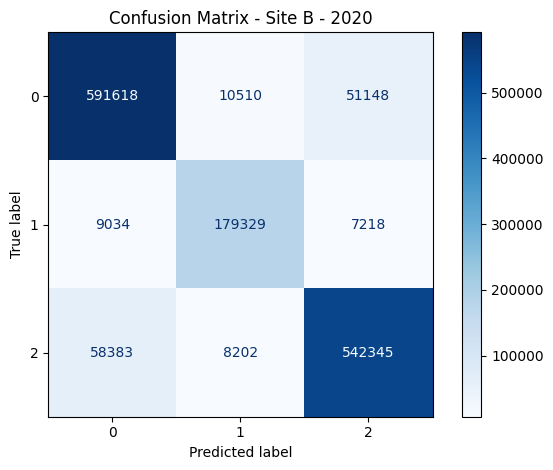


Training with 45000 samples...


Training Epoch 1: 100%|██████████| 704/704 [00:15<00:00, 44.51it/s]


Loss: 0.2431 + 1e-08 * 2807804.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.39it/s]


Epoch [1/15] Train Loss: 0.3684, Train Acc: 0.8684 | Val Loss: 0.2920, Val Acc: 0.8959


Training Epoch 2: 100%|██████████| 704/704 [00:15<00:00, 44.41it/s]


Loss: 0.4301 + 1e-08 * 2722068.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.98it/s]


Epoch [2/15] Train Loss: 0.2884, Train Acc: 0.8972 | Val Loss: 0.2842, Val Acc: 0.8984


Training Epoch 3: 100%|██████████| 704/704 [00:15<00:00, 44.46it/s]


Loss: 0.1687 + 1e-08 * 2647305.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.92it/s]


Epoch [3/15] Train Loss: 0.2697, Train Acc: 0.9045 | Val Loss: 0.2687, Val Acc: 0.9041


Training Epoch 4: 100%|██████████| 704/704 [00:15<00:00, 44.58it/s]


Loss: 0.8224 + 1e-08 * 2579060.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.63it/s]


Epoch [4/15] Train Loss: 0.2568, Train Acc: 0.9088 | Val Loss: 0.2699, Val Acc: 0.9051


Training Epoch 5: 100%|██████████| 704/704 [00:15<00:00, 44.57it/s]


Loss: 0.1771 + 1e-08 * 2531398.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.85it/s]


Epoch [5/15] Train Loss: 0.2481, Train Acc: 0.9115 | Val Loss: 0.2639, Val Acc: 0.9061


Training Epoch 6: 100%|██████████| 704/704 [00:15<00:00, 44.50it/s]


Loss: 0.2047 + 1e-08 * 2492231.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.37it/s]


Epoch [6/15] Train Loss: 0.2366, Train Acc: 0.9159 | Val Loss: 0.2616, Val Acc: 0.9073


Training Epoch 7: 100%|██████████| 704/704 [00:15<00:00, 44.48it/s]


Loss: 0.0824 + 1e-08 * 2464572.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.04it/s]


Epoch [7/15] Train Loss: 0.2289, Train Acc: 0.9195 | Val Loss: 0.2664, Val Acc: 0.9050


Training Epoch 8: 100%|██████████| 704/704 [00:15<00:00, 44.41it/s]


Loss: 0.9918 + 1e-08 * 2448445.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.77it/s]


Epoch [8/15] Train Loss: 0.2227, Train Acc: 0.9215 | Val Loss: 0.2620, Val Acc: 0.9084


Training Epoch 9: 100%|██████████| 704/704 [00:15<00:00, 44.51it/s]


Loss: 0.0128 + 1e-08 * 2438160.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.66it/s]


Epoch [9/15] Train Loss: 0.2153, Train Acc: 0.9238 | Val Loss: 0.2602, Val Acc: 0.9089


Training Epoch 10: 100%|██████████| 704/704 [00:15<00:00, 44.64it/s]


Loss: 0.2104 + 1e-08 * 2434966.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.24it/s]


Epoch [10/15] Train Loss: 0.2073, Train Acc: 0.9264 | Val Loss: 0.2651, Val Acc: 0.9075


Training Epoch 11: 100%|██████████| 704/704 [00:15<00:00, 44.63it/s]


Loss: 0.3815 + 1e-08 * 2436252.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.25it/s]


Epoch [11/15] Train Loss: 0.2016, Train Acc: 0.9287 | Val Loss: 0.2711, Val Acc: 0.9058


Training Epoch 12: 100%|██████████| 704/704 [00:15<00:00, 44.62it/s]


Loss: 0.5850 + 1e-08 * 2444588.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.01it/s]


Epoch [12/15] Train Loss: 0.1944, Train Acc: 0.9315 | Val Loss: 0.2779, Val Acc: 0.9020


Training Epoch 13: 100%|██████████| 704/704 [00:15<00:00, 44.42it/s]


Loss: 0.2514 + 1e-08 * 2453105.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.10it/s]


Epoch [13/15] Train Loss: 0.1878, Train Acc: 0.9342 | Val Loss: 0.2745, Val Acc: 0.9052


Training Epoch 14: 100%|██████████| 704/704 [00:15<00:00, 44.54it/s]


Loss: 0.3907 + 1e-08 * 2462848.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.73it/s]


Epoch [14/15] Train Loss: 0.1791, Train Acc: 0.9384 | Val Loss: 0.2860, Val Acc: 0.9019


Training Epoch 15: 100%|██████████| 704/704 [00:15<00:00, 44.43it/s]


Loss: 0.2638 + 1e-08 * 2479045.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.83it/s]


Epoch [15/15] Train Loss: 0.1744, Train Acc: 0.9397 | Val Loss: 0.2936, Val Acc: 0.9002


Stochastic Validation (T=15): 100%|██████████| 22778/22778 [02:37<00:00, 144.84it/s]


Stochastic Accuracy (mean over T): 0.9006
Cohen's Kappa: 0.8369
Per-class F1: [0.90041313 0.90704928 0.89872041]
Average F1 (macro): 0.9021


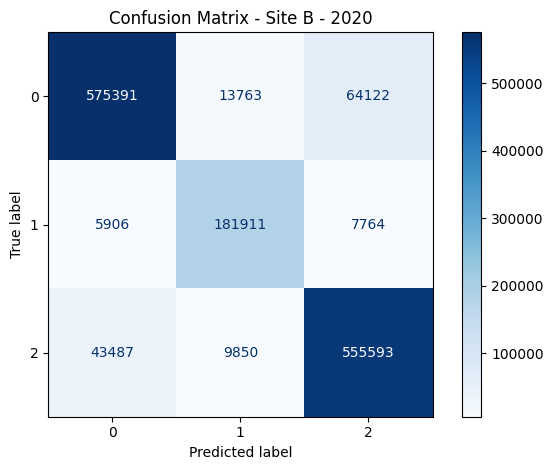


Training with 50000 samples...


Training Epoch 1: 100%|██████████| 782/782 [00:17<00:00, 44.55it/s]


Loss: 0.1950 + 1e-08 * 2796546.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.26it/s]


Epoch [1/15] Train Loss: 0.3610, Train Acc: 0.8729 | Val Loss: 0.2906, Val Acc: 0.8963


Training Epoch 2: 100%|██████████| 782/782 [00:17<00:00, 44.67it/s]


Loss: 0.2184 + 1e-08 * 2701771.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.96it/s]


Epoch [2/15] Train Loss: 0.2842, Train Acc: 0.8989 | Val Loss: 0.2801, Val Acc: 0.8999


Training Epoch 3: 100%|██████████| 782/782 [00:17<00:00, 44.59it/s]


Loss: 0.2053 + 1e-08 * 2616276.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.15it/s]


Epoch [3/15] Train Loss: 0.2664, Train Acc: 0.9059 | Val Loss: 0.2667, Val Acc: 0.9063


Training Epoch 4: 100%|██████████| 782/782 [00:17<00:00, 44.44it/s]


Loss: 0.0894 + 1e-08 * 2548356.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.73it/s]


Epoch [4/15] Train Loss: 0.2557, Train Acc: 0.9090 | Val Loss: 0.2640, Val Acc: 0.9065


Training Epoch 5: 100%|██████████| 782/782 [00:17<00:00, 44.49it/s]


Loss: 0.1072 + 1e-08 * 2496005.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.80it/s]


Epoch [5/15] Train Loss: 0.2449, Train Acc: 0.9138 | Val Loss: 0.2650, Val Acc: 0.9044


Training Epoch 6: 100%|██████████| 782/782 [00:17<00:00, 44.45it/s]


Loss: 0.3638 + 1e-08 * 2453311.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.55it/s]


Epoch [6/15] Train Loss: 0.2354, Train Acc: 0.9169 | Val Loss: 0.2608, Val Acc: 0.9067


Training Epoch 7: 100%|██████████| 782/782 [00:17<00:00, 44.55it/s]


Loss: 0.2280 + 1e-08 * 2423802.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.43it/s]


Epoch [7/15] Train Loss: 0.2278, Train Acc: 0.9197 | Val Loss: 0.2611, Val Acc: 0.9089


Training Epoch 8: 100%|██████████| 782/782 [00:17<00:00, 44.62it/s]


Loss: 0.1103 + 1e-08 * 2406113.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.03it/s]


Epoch [8/15] Train Loss: 0.2190, Train Acc: 0.9234 | Val Loss: 0.2611, Val Acc: 0.9067


Training Epoch 9: 100%|██████████| 782/782 [00:17<00:00, 44.51it/s]


Loss: 0.1182 + 1e-08 * 2397034.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.39it/s]


Epoch [9/15] Train Loss: 0.2154, Train Acc: 0.9240 | Val Loss: 0.2579, Val Acc: 0.9095


Training Epoch 10: 100%|██████████| 782/782 [00:17<00:00, 44.53it/s]


Loss: 0.4572 + 1e-08 * 2391507.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.51it/s]


Epoch [10/15] Train Loss: 0.2050, Train Acc: 0.9272 | Val Loss: 0.2623, Val Acc: 0.9091


Training Epoch 11: 100%|██████████| 782/782 [00:17<00:00, 44.53it/s]


Loss: 0.1705 + 1e-08 * 2393333.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.24it/s]


Epoch [11/15] Train Loss: 0.2013, Train Acc: 0.9285 | Val Loss: 0.2602, Val Acc: 0.9067


Training Epoch 12: 100%|██████████| 782/782 [00:17<00:00, 44.54it/s]


Loss: 0.4083 + 1e-08 * 2399919.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.61it/s]


Epoch [12/15] Train Loss: 0.1925, Train Acc: 0.9320 | Val Loss: 0.2691, Val Acc: 0.9073


Training Epoch 13: 100%|██████████| 782/782 [00:17<00:00, 44.46it/s]


Loss: 0.1845 + 1e-08 * 2410584.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.44it/s]


Epoch [13/15] Train Loss: 0.1860, Train Acc: 0.9337 | Val Loss: 0.2767, Val Acc: 0.9032


Training Epoch 14: 100%|██████████| 782/782 [00:17<00:00, 44.45it/s]


Loss: 0.0543 + 1e-08 * 2426376.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.58it/s]


Epoch [14/15] Train Loss: 0.1790, Train Acc: 0.9376 | Val Loss: 0.2811, Val Acc: 0.9058


Training Epoch 15: 100%|██████████| 782/782 [00:17<00:00, 44.42it/s]


Loss: 0.2768 + 1e-08 * 2444266.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.24it/s]


Epoch [15/15] Train Loss: 0.1737, Train Acc: 0.9391 | Val Loss: 0.2902, Val Acc: 0.9034


Stochastic Validation (T=15): 100%|██████████| 22778/22778 [02:37<00:00, 144.48it/s]


Stochastic Accuracy (mean over T): 0.9039
Cohen's Kappa: 0.8420
Per-class F1: [0.90333055 0.90974244 0.90249165]
Average F1 (macro): 0.9052


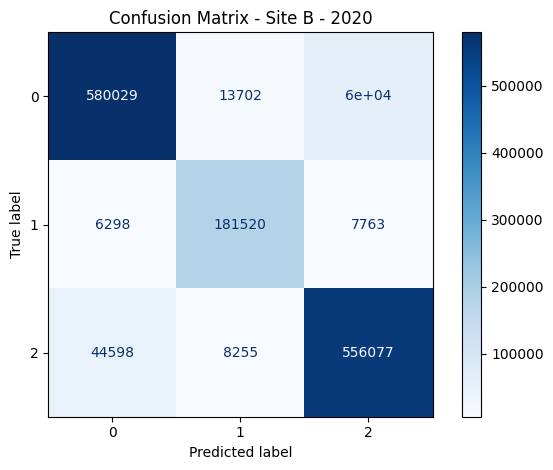


Training with 55000 samples...


Training Epoch 1: 100%|██████████| 860/860 [00:19<00:00, 44.56it/s]


Loss: 0.3264 + 1e-08 * 2789106.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.92it/s]


Epoch [1/15] Train Loss: 0.3516, Train Acc: 0.8760 | Val Loss: 0.2856, Val Acc: 0.8962


Training Epoch 2: 100%|██████████| 860/860 [00:19<00:00, 44.37it/s]


Loss: 0.2400 + 1e-08 * 2682840.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.64it/s]


Epoch [2/15] Train Loss: 0.2793, Train Acc: 0.9010 | Val Loss: 0.2706, Val Acc: 0.9053


Training Epoch 3: 100%|██████████| 860/860 [00:19<00:00, 44.41it/s]


Loss: 0.1603 + 1e-08 * 2592939.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.47it/s]


Epoch [3/15] Train Loss: 0.2622, Train Acc: 0.9074 | Val Loss: 0.2670, Val Acc: 0.9060


Training Epoch 4: 100%|██████████| 860/860 [00:19<00:00, 44.49it/s]


Loss: 0.2566 + 1e-08 * 2521251.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.47it/s]


Epoch [4/15] Train Loss: 0.2512, Train Acc: 0.9109 | Val Loss: 0.2635, Val Acc: 0.9053


Training Epoch 5: 100%|██████████| 860/860 [00:19<00:00, 44.33it/s]


Loss: 0.0625 + 1e-08 * 2469254.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.31it/s]


Epoch [5/15] Train Loss: 0.2426, Train Acc: 0.9140 | Val Loss: 0.2608, Val Acc: 0.9067


Training Epoch 6: 100%|██████████| 860/860 [00:19<00:00, 44.36it/s]


Loss: 0.0920 + 1e-08 * 2430177.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.33it/s]


Epoch [6/15] Train Loss: 0.2342, Train Acc: 0.9171 | Val Loss: 0.2618, Val Acc: 0.9077


Training Epoch 7: 100%|██████████| 860/860 [00:19<00:00, 44.39it/s]


Loss: 0.4548 + 1e-08 * 2398922.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.01it/s]


Epoch [7/15] Train Loss: 0.2245, Train Acc: 0.9207 | Val Loss: 0.2606, Val Acc: 0.9074


Training Epoch 8: 100%|██████████| 860/860 [00:19<00:00, 44.49it/s]


Loss: 0.2861 + 1e-08 * 2378228.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.06it/s]


Epoch [8/15] Train Loss: 0.2180, Train Acc: 0.9226 | Val Loss: 0.2595, Val Acc: 0.9060


Training Epoch 9: 100%|██████████| 860/860 [00:19<00:00, 44.47it/s]


Loss: 0.2339 + 1e-08 * 2365337.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.00it/s]


Epoch [9/15] Train Loss: 0.2125, Train Acc: 0.9259 | Val Loss: 0.2625, Val Acc: 0.9075


Training Epoch 10: 100%|██████████| 860/860 [00:19<00:00, 44.39it/s]


Loss: 0.2894 + 1e-08 * 2360247.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.14it/s]


Epoch [10/15] Train Loss: 0.2046, Train Acc: 0.9283 | Val Loss: 0.2671, Val Acc: 0.9072


Training Epoch 11: 100%|██████████| 860/860 [00:19<00:00, 44.45it/s]


Loss: 0.3900 + 1e-08 * 2363167.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.03it/s]


Epoch [11/15] Train Loss: 0.1987, Train Acc: 0.9298 | Val Loss: 0.2743, Val Acc: 0.9015


Training Epoch 12: 100%|██████████| 860/860 [00:19<00:00, 44.43it/s]


Loss: 0.2215 + 1e-08 * 2366662.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.21it/s]


Epoch [12/15] Train Loss: 0.1921, Train Acc: 0.9322 | Val Loss: 0.2675, Val Acc: 0.9063


Training Epoch 13: 100%|██████████| 860/860 [00:19<00:00, 44.32it/s]


Loss: 0.1281 + 1e-08 * 2376804.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.06it/s]


Epoch [13/15] Train Loss: 0.1882, Train Acc: 0.9345 | Val Loss: 0.2697, Val Acc: 0.9057


Training Epoch 14: 100%|██████████| 860/860 [00:19<00:00, 44.36it/s]


Loss: 0.1185 + 1e-08 * 2394575.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.11it/s]


Epoch [14/15] Train Loss: 0.1811, Train Acc: 0.9381 | Val Loss: 0.2732, Val Acc: 0.9053


Training Epoch 15: 100%|██████████| 860/860 [00:19<00:00, 44.32it/s]


Loss: 0.1483 + 1e-08 * 2409091.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.71it/s]


Epoch [15/15] Train Loss: 0.1743, Train Acc: 0.9391 | Val Loss: 0.2852, Val Acc: 0.9039


Stochastic Validation (T=15): 100%|██████████| 22778/22778 [02:37<00:00, 144.66it/s]


Stochastic Accuracy (mean over T): 0.9049
Cohen's Kappa: 0.8439
Per-class F1: [0.90600895 0.90740736 0.90289078]
Average F1 (macro): 0.9054


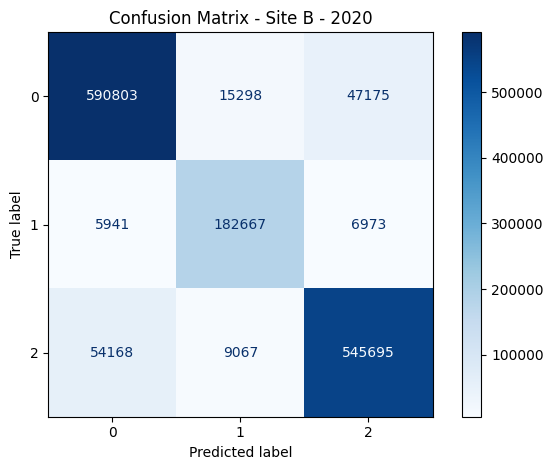


Training with 60000 samples...


Training Epoch 1: 100%|██████████| 938/938 [00:21<00:00, 44.49it/s]


Loss: 0.2099 + 1e-08 * 2774580.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.37it/s]


Epoch [1/15] Train Loss: 0.3458, Train Acc: 0.8766 | Val Loss: 0.2835, Val Acc: 0.8976


Training Epoch 2: 100%|██████████| 938/938 [00:21<00:00, 44.65it/s]


Loss: 0.6195 + 1e-08 * 2661327.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.57it/s]


Epoch [2/15] Train Loss: 0.2767, Train Acc: 0.9020 | Val Loss: 0.2786, Val Acc: 0.9016


Training Epoch 3: 100%|██████████| 938/938 [00:21<00:00, 44.59it/s]


Loss: 0.3132 + 1e-08 * 2565530.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.23it/s]


Epoch [3/15] Train Loss: 0.2604, Train Acc: 0.9074 | Val Loss: 0.2627, Val Acc: 0.9060


Training Epoch 4: 100%|██████████| 938/938 [00:21<00:00, 44.42it/s]


Loss: 0.2114 + 1e-08 * 2486500.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.34it/s]


Epoch [4/15] Train Loss: 0.2480, Train Acc: 0.9117 | Val Loss: 0.2667, Val Acc: 0.9049


Training Epoch 5: 100%|██████████| 938/938 [00:21<00:00, 44.41it/s]


Loss: 0.1389 + 1e-08 * 2424020.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.16it/s]


Epoch [5/15] Train Loss: 0.2391, Train Acc: 0.9152 | Val Loss: 0.2631, Val Acc: 0.9079


Training Epoch 6: 100%|██████████| 938/938 [00:21<00:00, 44.45it/s]


Loss: 0.1025 + 1e-08 * 2380518.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.68it/s]


Epoch [6/15] Train Loss: 0.2323, Train Acc: 0.9176 | Val Loss: 0.2582, Val Acc: 0.9075


Training Epoch 7: 100%|██████████| 938/938 [00:21<00:00, 44.51it/s]


Loss: 0.3477 + 1e-08 * 2344654.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.51it/s]


Epoch [7/15] Train Loss: 0.2231, Train Acc: 0.9207 | Val Loss: 0.2553, Val Acc: 0.9080


Training Epoch 8: 100%|██████████| 938/938 [00:21<00:00, 44.51it/s]


Loss: 0.0847 + 1e-08 * 2327342.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.95it/s]


Epoch [8/15] Train Loss: 0.2169, Train Acc: 0.9232 | Val Loss: 0.2560, Val Acc: 0.9090


Training Epoch 9: 100%|██████████| 938/938 [00:21<00:00, 44.45it/s]


Loss: 0.1579 + 1e-08 * 2314385.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.39it/s]


Epoch [9/15] Train Loss: 0.2111, Train Acc: 0.9242 | Val Loss: 0.2607, Val Acc: 0.9073


Training Epoch 10: 100%|██████████| 938/938 [00:21<00:00, 44.46it/s]


Loss: 0.1884 + 1e-08 * 2309592.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.32it/s]


Epoch [10/15] Train Loss: 0.2057, Train Acc: 0.9281 | Val Loss: 0.2701, Val Acc: 0.9063


Training Epoch 11: 100%|██████████| 938/938 [00:21<00:00, 44.45it/s]


Loss: 0.1473 + 1e-08 * 2310612.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.38it/s]


Epoch [11/15] Train Loss: 0.1986, Train Acc: 0.9300 | Val Loss: 0.2616, Val Acc: 0.9079


Training Epoch 12: 100%|██████████| 938/938 [00:21<00:00, 44.45it/s]


Loss: 0.2292 + 1e-08 * 2318038.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.59it/s]


Epoch [12/15] Train Loss: 0.1947, Train Acc: 0.9306 | Val Loss: 0.2623, Val Acc: 0.9070


Training Epoch 13: 100%|██████████| 938/938 [00:21<00:00, 44.60it/s]


Loss: 0.1536 + 1e-08 * 2327596.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 147.06it/s]


Epoch [13/15] Train Loss: 0.1874, Train Acc: 0.9339 | Val Loss: 0.2718, Val Acc: 0.9042


Training Epoch 14: 100%|██████████| 938/938 [00:21<00:00, 44.51it/s]


Loss: 0.1029 + 1e-08 * 2344760.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.33it/s]


Epoch [14/15] Train Loss: 0.1818, Train Acc: 0.9356 | Val Loss: 0.2710, Val Acc: 0.9079


Training Epoch 15: 100%|██████████| 938/938 [00:21<00:00, 44.44it/s]


Loss: 0.0496 + 1e-08 * 2359975.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.01it/s]


Epoch [15/15] Train Loss: 0.1755, Train Acc: 0.9378 | Val Loss: 0.2768, Val Acc: 0.9052


Stochastic Validation (T=15): 100%|██████████| 22778/22778 [02:37<00:00, 144.65it/s]


Stochastic Accuracy (mean over T): 0.9047
Cohen's Kappa: 0.8429
Per-class F1: [0.90438802 0.91810001 0.90062548]
Average F1 (macro): 0.9077


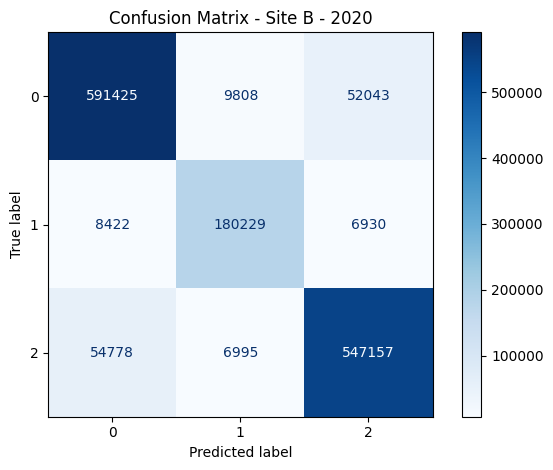


Training with 65000 samples...


Training Epoch 1: 100%|██████████| 1016/1016 [00:22<00:00, 44.48it/s]


Loss: 0.1534 + 1e-08 * 2769979.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.17it/s]


Epoch [1/15] Train Loss: 0.3452, Train Acc: 0.8758 | Val Loss: 0.2904, Val Acc: 0.8974


Training Epoch 2: 100%|██████████| 1016/1016 [00:22<00:00, 44.42it/s]


Loss: 0.1691 + 1e-08 * 2647891.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.18it/s]


Epoch [2/15] Train Loss: 0.2758, Train Acc: 0.9020 | Val Loss: 0.2667, Val Acc: 0.9055


Training Epoch 3: 100%|██████████| 1016/1016 [00:22<00:00, 44.52it/s]


Loss: 0.2530 + 1e-08 * 2546222.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.37it/s]


Epoch [3/15] Train Loss: 0.2609, Train Acc: 0.9075 | Val Loss: 0.2656, Val Acc: 0.9042


Training Epoch 4: 100%|██████████| 1016/1016 [00:22<00:00, 44.36it/s]


Loss: 0.1468 + 1e-08 * 2470704.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.37it/s]


Epoch [4/15] Train Loss: 0.2499, Train Acc: 0.9124 | Val Loss: 0.2615, Val Acc: 0.9070


Training Epoch 5: 100%|██████████| 1016/1016 [00:22<00:00, 44.36it/s]


Loss: 0.2819 + 1e-08 * 2409775.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.11it/s]


Epoch [5/15] Train Loss: 0.2390, Train Acc: 0.9156 | Val Loss: 0.2537, Val Acc: 0.9094


Training Epoch 6: 100%|██████████| 1016/1016 [00:22<00:00, 44.44it/s]


Loss: 0.1519 + 1e-08 * 2366393.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.30it/s]


Epoch [6/15] Train Loss: 0.2310, Train Acc: 0.9177 | Val Loss: 0.2534, Val Acc: 0.9089


Training Epoch 7: 100%|██████████| 1016/1016 [00:22<00:00, 44.41it/s]


Loss: 0.2102 + 1e-08 * 2337223.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.13it/s]


Epoch [7/15] Train Loss: 0.2251, Train Acc: 0.9197 | Val Loss: 0.2543, Val Acc: 0.9079


Training Epoch 8: 100%|██████████| 1016/1016 [00:22<00:00, 44.51it/s]


Loss: 0.0767 + 1e-08 * 2315854.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.39it/s]


Epoch [8/15] Train Loss: 0.2176, Train Acc: 0.9224 | Val Loss: 0.2579, Val Acc: 0.9082


Training Epoch 9: 100%|██████████| 1016/1016 [00:22<00:00, 44.37it/s]


Loss: 0.1140 + 1e-08 * 2303207.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.39it/s]


Epoch [9/15] Train Loss: 0.2119, Train Acc: 0.9240 | Val Loss: 0.2567, Val Acc: 0.9082


Training Epoch 10: 100%|██████████| 1016/1016 [00:22<00:00, 44.38it/s]


Loss: 0.1341 + 1e-08 * 2299017.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.63it/s]


Epoch [10/15] Train Loss: 0.2036, Train Acc: 0.9273 | Val Loss: 0.2568, Val Acc: 0.9087


Training Epoch 11: 100%|██████████| 1016/1016 [00:22<00:00, 44.41it/s]


Loss: 0.2135 + 1e-08 * 2300276.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.06it/s]


Epoch [11/15] Train Loss: 0.1983, Train Acc: 0.9302 | Val Loss: 0.2606, Val Acc: 0.9095


Training Epoch 12: 100%|██████████| 1016/1016 [00:22<00:00, 44.44it/s]


Loss: 0.1386 + 1e-08 * 2307661.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.16it/s]


Epoch [12/15] Train Loss: 0.1938, Train Acc: 0.9316 | Val Loss: 0.2652, Val Acc: 0.9079


Training Epoch 13: 100%|██████████| 1016/1016 [00:22<00:00, 44.42it/s]


Loss: 0.0706 + 1e-08 * 2320155.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.25it/s]


Epoch [13/15] Train Loss: 0.1877, Train Acc: 0.9343 | Val Loss: 0.2654, Val Acc: 0.9063


Training Epoch 14: 100%|██████████| 1016/1016 [00:22<00:00, 44.23it/s]


Loss: 0.1626 + 1e-08 * 2333918.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.72it/s]


Epoch [14/15] Train Loss: 0.1813, Train Acc: 0.9351 | Val Loss: 0.2665, Val Acc: 0.9084


Training Epoch 15: 100%|██████████| 1016/1016 [00:22<00:00, 44.31it/s]


Loss: 0.2383 + 1e-08 * 2353336.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.51it/s]


Epoch [15/15] Train Loss: 0.1756, Train Acc: 0.9385 | Val Loss: 0.2700, Val Acc: 0.9082


Stochastic Validation (T=15): 100%|██████████| 22778/22778 [02:37<00:00, 144.97it/s]


Stochastic Accuracy (mean over T): 0.9079
Cohen's Kappa: 0.8484
Per-class F1: [0.90848221 0.91652923 0.90437544]
Average F1 (macro): 0.9098


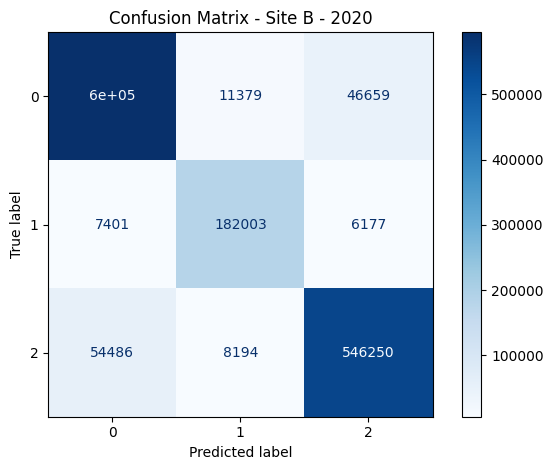


Training with 70000 samples...


Training Epoch 1: 100%|██████████| 1094/1094 [00:24<00:00, 44.48it/s]


Loss: 0.5761 + 1e-08 * 2756006.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.15it/s]


Epoch [1/15] Train Loss: 0.3370, Train Acc: 0.8799 | Val Loss: 0.2835, Val Acc: 0.8980


Training Epoch 2: 100%|██████████| 1094/1094 [00:24<00:00, 44.46it/s]


Loss: 0.1669 + 1e-08 * 2622425.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.32it/s]


Epoch [2/15] Train Loss: 0.2717, Train Acc: 0.9032 | Val Loss: 0.2719, Val Acc: 0.9032


Training Epoch 3: 100%|██████████| 1094/1094 [00:24<00:00, 44.45it/s]


Loss: 0.1772 + 1e-08 * 2519403.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.11it/s]


Epoch [3/15] Train Loss: 0.2576, Train Acc: 0.9084 | Val Loss: 0.2689, Val Acc: 0.9052


Training Epoch 4: 100%|██████████| 1094/1094 [00:24<00:00, 44.34it/s]


Loss: 0.2723 + 1e-08 * 2434093.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.15it/s]


Epoch [4/15] Train Loss: 0.2460, Train Acc: 0.9120 | Val Loss: 0.2711, Val Acc: 0.9036


Training Epoch 5: 100%|██████████| 1094/1094 [00:24<00:00, 44.56it/s]


Loss: 0.1198 + 1e-08 * 2374126.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.29it/s]


Epoch [5/15] Train Loss: 0.2381, Train Acc: 0.9143 | Val Loss: 0.2602, Val Acc: 0.9063


Training Epoch 6: 100%|██████████| 1094/1094 [00:24<00:00, 44.47it/s]


Loss: 0.1845 + 1e-08 * 2332390.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.53it/s]


Epoch [6/15] Train Loss: 0.2300, Train Acc: 0.9181 | Val Loss: 0.2536, Val Acc: 0.9096


Training Epoch 7: 100%|██████████| 1094/1094 [00:24<00:00, 44.53it/s]


Loss: 0.2655 + 1e-08 * 2301466.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.53it/s]


Epoch [7/15] Train Loss: 0.2228, Train Acc: 0.9210 | Val Loss: 0.2542, Val Acc: 0.9073


Training Epoch 8: 100%|██████████| 1094/1094 [00:24<00:00, 44.43it/s]


Loss: 0.0704 + 1e-08 * 2279961.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.26it/s]


Epoch [8/15] Train Loss: 0.2152, Train Acc: 0.9237 | Val Loss: 0.2626, Val Acc: 0.9032


Training Epoch 9: 100%|██████████| 1094/1094 [00:24<00:00, 44.45it/s]


Loss: 0.1439 + 1e-08 * 2270323.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.29it/s]


Epoch [9/15] Train Loss: 0.2096, Train Acc: 0.9250 | Val Loss: 0.2533, Val Acc: 0.9081


Training Epoch 10: 100%|██████████| 1094/1094 [00:24<00:00, 44.44it/s]


Loss: 0.2538 + 1e-08 * 2269023.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.05it/s]


Epoch [10/15] Train Loss: 0.2040, Train Acc: 0.9271 | Val Loss: 0.2558, Val Acc: 0.9093


Training Epoch 11: 100%|██████████| 1094/1094 [00:24<00:00, 44.46it/s]


Loss: 0.1670 + 1e-08 * 2275468.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.53it/s]


Epoch [11/15] Train Loss: 0.1979, Train Acc: 0.9306 | Val Loss: 0.2652, Val Acc: 0.9057


Training Epoch 12: 100%|██████████| 1094/1094 [00:24<00:00, 44.46it/s]


Loss: 0.1109 + 1e-08 * 2283429.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.72it/s]


Epoch [12/15] Train Loss: 0.1932, Train Acc: 0.9316 | Val Loss: 0.2587, Val Acc: 0.9094


Training Epoch 13: 100%|██████████| 1094/1094 [00:24<00:00, 44.37it/s]


Loss: 0.1150 + 1e-08 * 2297083.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.75it/s]


Epoch [13/15] Train Loss: 0.1869, Train Acc: 0.9349 | Val Loss: 0.2606, Val Acc: 0.9095


Training Epoch 14: 100%|██████████| 1094/1094 [00:24<00:00, 44.36it/s]


Loss: 0.2835 + 1e-08 * 2315570.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.62it/s]


Epoch [14/15] Train Loss: 0.1805, Train Acc: 0.9362 | Val Loss: 0.2682, Val Acc: 0.9081


Training Epoch 15: 100%|██████████| 1094/1094 [00:24<00:00, 44.30it/s]


Loss: 0.2057 + 1e-08 * 2337152.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.80it/s]


Epoch [15/15] Train Loss: 0.1770, Train Acc: 0.9387 | Val Loss: 0.2668, Val Acc: 0.9078


Stochastic Validation (T=15): 100%|██████████| 22778/22778 [02:37<00:00, 145.05it/s]


Stochastic Accuracy (mean over T): 0.9081
Cohen's Kappa: 0.8490
Per-class F1: [0.90918215 0.91264262 0.90540271]
Average F1 (macro): 0.9091


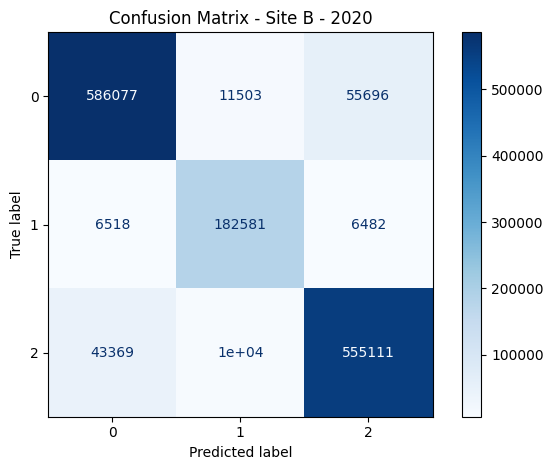


Training with 75000 samples...


Training Epoch 1: 100%|██████████| 1172/1172 [00:26<00:00, 44.56it/s]


Loss: 0.4204 + 1e-08 * 2751251.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.38it/s]


Epoch [1/15] Train Loss: 0.3353, Train Acc: 0.8811 | Val Loss: 0.2806, Val Acc: 0.9009


Training Epoch 2: 100%|██████████| 1172/1172 [00:26<00:00, 44.42it/s]


Loss: 0.3516 + 1e-08 * 2608192.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.45it/s]


Epoch [2/15] Train Loss: 0.2724, Train Acc: 0.9039 | Val Loss: 0.2647, Val Acc: 0.9046


Training Epoch 3: 100%|██████████| 1172/1172 [00:26<00:00, 44.50it/s]


Loss: 0.2644 + 1e-08 * 2496402.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.62it/s]


Epoch [3/15] Train Loss: 0.2562, Train Acc: 0.9081 | Val Loss: 0.2577, Val Acc: 0.9096


Training Epoch 4: 100%|██████████| 1172/1172 [00:26<00:00, 44.52it/s]


Loss: 0.2773 + 1e-08 * 2409616.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.23it/s]


Epoch [4/15] Train Loss: 0.2468, Train Acc: 0.9118 | Val Loss: 0.2517, Val Acc: 0.9103


Training Epoch 5: 100%|██████████| 1172/1172 [00:26<00:00, 44.53it/s]


Loss: 0.1849 + 1e-08 * 2347632.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.49it/s]


Epoch [5/15] Train Loss: 0.2374, Train Acc: 0.9156 | Val Loss: 0.2601, Val Acc: 0.9068


Training Epoch 6: 100%|██████████| 1172/1172 [00:26<00:00, 44.52it/s]


Loss: 0.4289 + 1e-08 * 2303151.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.82it/s]


Epoch [6/15] Train Loss: 0.2299, Train Acc: 0.9178 | Val Loss: 0.2650, Val Acc: 0.9053


Training Epoch 7: 100%|██████████| 1172/1172 [00:26<00:00, 44.41it/s]


Loss: 0.3550 + 1e-08 * 2272035.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.96it/s]


Epoch [7/15] Train Loss: 0.2223, Train Acc: 0.9205 | Val Loss: 0.2513, Val Acc: 0.9083


Training Epoch 8: 100%|██████████| 1172/1172 [00:26<00:00, 44.55it/s]


Loss: 0.0816 + 1e-08 * 2249779.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.51it/s]


Epoch [8/15] Train Loss: 0.2159, Train Acc: 0.9224 | Val Loss: 0.2542, Val Acc: 0.9095


Training Epoch 9: 100%|██████████| 1172/1172 [00:26<00:00, 44.49it/s]


Loss: 0.1846 + 1e-08 * 2239314.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.05it/s]


Epoch [9/15] Train Loss: 0.2101, Train Acc: 0.9254 | Val Loss: 0.2562, Val Acc: 0.9082


Training Epoch 10: 100%|██████████| 1172/1172 [00:26<00:00, 44.39it/s]


Loss: 0.1286 + 1e-08 * 2236997.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.99it/s]


Epoch [10/15] Train Loss: 0.2049, Train Acc: 0.9275 | Val Loss: 0.2549, Val Acc: 0.9084


Training Epoch 11: 100%|██████████| 1172/1172 [00:26<00:00, 44.01it/s]


Loss: 0.2008 + 1e-08 * 2237750.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.73it/s]


Epoch [11/15] Train Loss: 0.1999, Train Acc: 0.9289 | Val Loss: 0.2532, Val Acc: 0.9107


Training Epoch 12: 100%|██████████| 1172/1172 [00:26<00:00, 44.25it/s]


Loss: 0.0699 + 1e-08 * 2250603.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 146.52it/s]


Epoch [12/15] Train Loss: 0.1945, Train Acc: 0.9305 | Val Loss: 0.2585, Val Acc: 0.9087


Training Epoch 13: 100%|██████████| 1172/1172 [00:26<00:00, 44.26it/s]


Loss: 0.0822 + 1e-08 * 2261147.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.79it/s]


Epoch [13/15] Train Loss: 0.1891, Train Acc: 0.9327 | Val Loss: 0.2573, Val Acc: 0.9097


Training Epoch 14: 100%|██████████| 1172/1172 [00:26<00:00, 44.21it/s]


Loss: 0.2968 + 1e-08 * 2277567.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.53it/s]


Epoch [14/15] Train Loss: 0.1836, Train Acc: 0.9353 | Val Loss: 0.2656, Val Acc: 0.9075


Stochastic Validation (T=15): 100%|██████████| 22778/22778 [02:37<00:00, 144.28it/s]


Stochastic Accuracy (mean over T): 0.8972
Cohen's Kappa: 0.8311
Per-class F1: [0.89321948 0.91442148 0.89575794]
Average F1 (macro): 0.9011


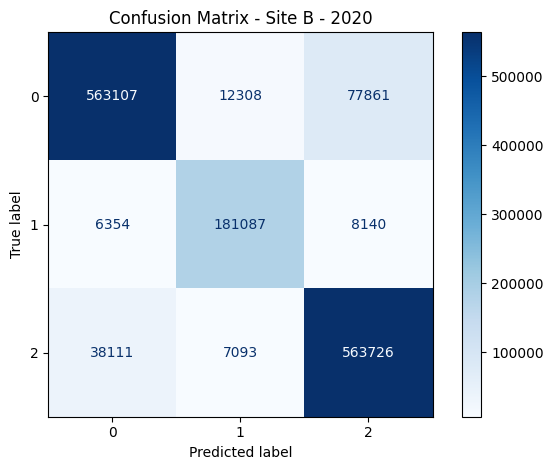

In [29]:
# Subsampled Training
if flag_subsampled:
    elbow_history = subsampled_training(X_train, y_train, val_dataloader, start=5000, end=75000, step=5000)
    
else: 
    # Simple training
    train_losses, val_losses, train_accs, val_accs = train(model, train_dataset, train_dataloader, val_dataloader, optimizer, KL_WEIGHT=KL_WEIGHT, EPOCHS=EPOCHS, T=T)

    acc, kappa, per_class_f1, avg_f1, cm = evaluate(model, test_dataloader, T, device=DEVICE)
    
    # Printing and plotting
    print("Stochastic" + f" Accuracy (mean over T): {acc:.4f}" if (T>1) else "Deterministic" + f" Accuracy (mean over T): {acc:.4f}")
    print(f"Cohen's Kappa: {kappa:.4f}")
    print(f"Per-class F1: {per_class_f1}")
    print(f"Average F1 (macro): {avg_f1:.4f}")
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues")
    plt.title(f"Confusion Matrix - Site {SITE} - {YEAR}")
    plt.tight_layout()
    plt.show()

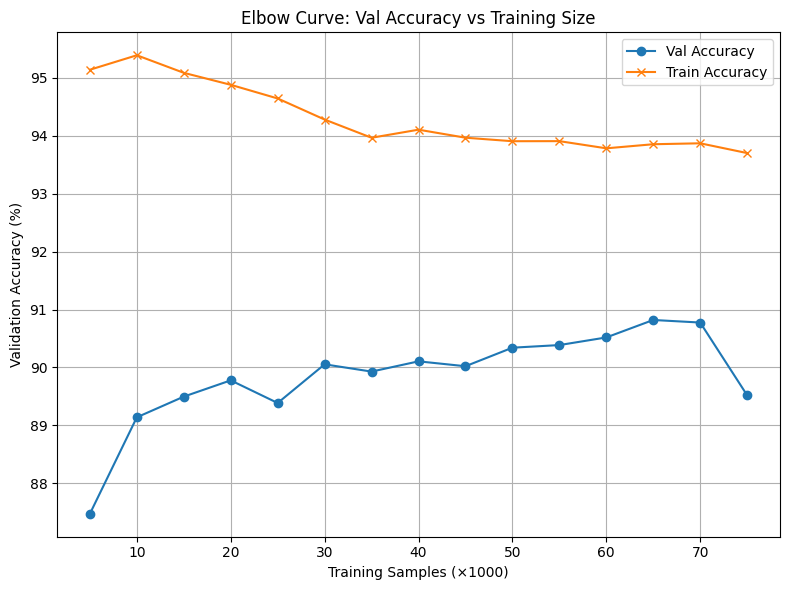

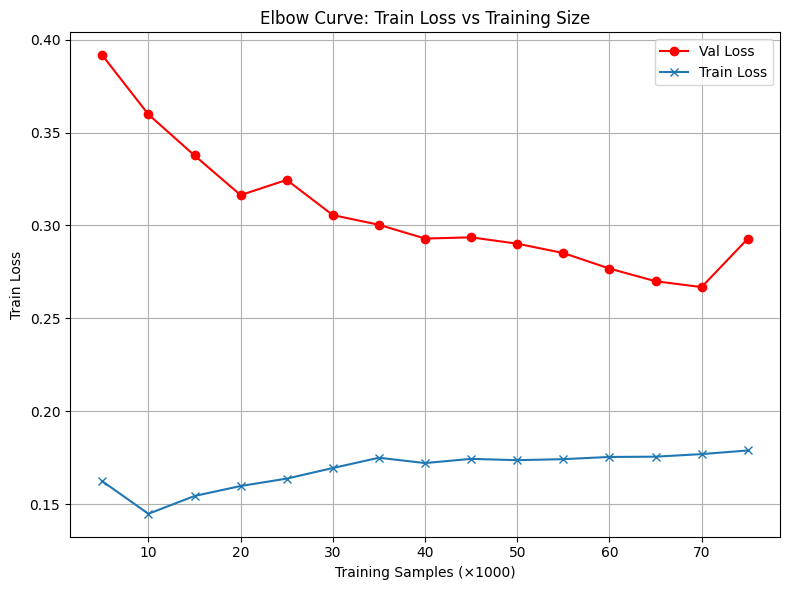

In [30]:
if flag_subsampled:
    def plot_elbow_curve(elbow_history):
        x_vals = [x / 1000 for x in elbow_history["subset_size"]]
    
        # Accuracy
        plt.figure(figsize=(8, 6))
        y_vals = [acc * 100 for acc in elbow_history["val_accuracy"]]
        plt.plot(x_vals, y_vals, marker='o', label='Val Accuracy')
        plt.plot(x_vals, [acc * 100 for acc in elbow_history['train_accuracy']], marker='x', label='Train Accuracy')
        plt.xlabel("Training Samples (×1000)")
        plt.ylabel("Validation Accuracy (%)")
        plt.title("Elbow Curve: Val Accuracy vs Training Size")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()
    
        # Train Loss
        plt.figure(figsize=(8, 6))
        y_vals = elbow_history["val_loss"]  # raw loss
        plt.plot(x_vals, y_vals, marker='o', color='red', label='Val Loss')
        plt.plot(x_vals, elbow_history["train_loss"], marker='x', label='Train Loss')
        plt.xlabel("Training Samples (×1000)")
        plt.ylabel("Train Loss")
        plt.title("Elbow Curve: Train Loss vs Training Size")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()
        
    plot_elbow_curve(elbow_history)

else: 
    epochs = range(1, EPOCHS + 1)

    plt.figure(figsize=(12, 5))
    
    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Train vs Val Loss')
    plt.legend()
    plt.grid(True)
    
    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accs, label='Train Accuracy')
    plt.plot(epochs, val_accs, label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Train vs Val Accuracy')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

## Saving Results

In [31]:
if flag_subsampled:
    def save_elbow_results_to_excel(filename, elbow_history):
        # Load or create workbook
        if os.path.exists(filename):
            wb = load_workbook(filename)
            ws = wb.active
        else:
            wb = Workbook()
            ws = wb.active
    
            # Header row with bold font
            headers = ["Experiments", "Results"]
            bold_font = Font(bold=True)
            ws.append(headers)
    
            for col_num in range(1, len(headers) + 1):
                ws.cell(row=1, column=col_num).font = bold_font
    
        # For each subset size, append a row
        for i in range(len(elbow_history["subset_size"])):
            subset = elbow_history["subset_size"][i]
            train_acc = elbow_history["train_accuracy"][i] * 100
            train_loss = elbow_history["train_loss"][i]
            val_acc = elbow_history["val_accuracy"][i] * 100
            val_loss = elbow_history["val_loss"][i]
            val_avg_f1 = elbow_history["val_avg_f1"][i] * 100
            kappa = elbow_history["kappa"][i]
    
    
            experiment_name = f"Labeled Samples: {subset}"
            results_str = (
                f"TrainAcc = {train_acc:.2f}%, "
                f"TrainLoss = {train_loss:.4f},\n"
                f"ValAcc = {val_acc:.2f}%, "
                f"ValLoss = {val_loss:.4f},\n"
                f"AvgF1 = {val_avg_f1:.2f}%, "
                f"Kappa = {kappa:.4f}"
            )
    
            ws.append([experiment_name, results_str])
    
        wb.save(filename)
        print(f"Results saved to {filename}")
    
save_elbow_results_to_excel(
    filename="Results.xlsx",
    elbow_history=elbow_history
)

Results saved to Results.xlsx


<hr>